# Evolving a Lunar Lander with differentiable Genetic Programming

## Installation
To install the required libraries run the command:

In [ ]:
!pip install -r requirements.txt

## Imports
Imports from the standard genepro-multi library are done here. Any adjustments (e.g. different operators) should be made in the notebook. For example:

```
class SmoothOperator(Node):
  def __init__(self):
    super(SmoothOperator,self).__init__()
    self.arity = 1
    self.symb = "SmoothOperator"

  def _get_args_repr(self, args):
    return self._get_typical_repr(args,'before')

  def get_output(self, X):
    c_outs = self._get_child_outputs(X)
    return np.smoothOperation(c_outs[0])

  def get_output_pt(self, X):
    c_outs = self._get_child_outputs_pt(X)
    return torch.smoothOperation(c_outs[0])
```

In [3]:
import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution
from genepro.node_impl import Constant

import torch
import torch.optim as optim

import random
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
from matplotlib import animation

## Reinforcement Learning Setup
Here we first setup the Gymnasium environment. Please see https://gymnasium.farama.org/environments/box2d/lunar_lander/ for more information on the environment. 

Then a memory buffer is made. This is a buffer in which state transitions are stored. When the buffer reaches its maximum capacity old transitions are replaced by new ones.

A frame buffer is initialised used to later store animation frames of the environment.

In [4]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __iadd__(self, other):
      self.memory += other.memory
      return self 

    def __add__(self, other):
      self.memory = self.memory + other.memory 
      return self

In [6]:
frames = []

## Fitness Function

Here you get to be creative. The default setup evaluates 5 episodes of 300 frames. Think of what action to pick and what fitness function to use. The Multi-tree takes an input of $n \times d$ where $n$ is a batch of size 1.

In [7]:
def fitness_function_pt(multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False):
  memory = ReplayMemory(10000)
  rewards = []

  for _ in range(num_episodes):
    # get initial state of the environment
    observation = env.reset()
    observation = observation[0]
    
    for _ in range(episode_duration):
      if render:
        frames.append(env.render())

      input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      
      # what goes here? TODO
      action =  torch.argmax(multitree.get_output_pt(input_sample))
      observation, reward, terminated, truncated, info = env.step(action.item())
      rewards.append(reward)
      output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      memory.push(input_sample, torch.tensor([[action.item()]]), output_sample, torch.tensor([reward]))
      if (terminated or truncated) and not ignore_done:
        break

  fitness = np.sum(rewards)
  
  return fitness, memory

## Evolution Setup
Here the leaf and internal nodes are defined. Think about the odds of sampling a constant in this default configurations. Also think about any operators that could be useful and add them here. 

Adjust the population size (multiple of 8 if you want to use the standard tournament selection), max generations and max tree size to taste. Be aware that each of these settings can increase the runtime.

In [29]:
num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes = leaf_nodes + [Constant()] # Think about the probability of sampling a coefficient
internal_nodes = [Plus(),Minus(),Times(),Div()] #Add your own operators here

evo = Evolution(
  fitness_function_pt, internal_nodes, leaf_nodes,
  4,
  pop_size=8,
  max_gens=3,
  max_tree_size=30,
  n_jobs=8,
  verbose=False)

## Evolve
Running this cell will use all the settings above as parameters

In [30]:
score_per_run = []
time_per_run = []
for i in range(10):
    evo = Evolution(
    fitness_function_pt, internal_nodes, leaf_nodes,
    4,
    pop_size=128,
    max_gens=30,
    max_tree_size=30,
    n_jobs=8,
    verbose=True)
    score_per_generation, time_per_generation = evo.evolve()

    score_per_run.append(score_per_generation)
    time_per_run.append(time_per_generation)
    print(f"score per generation in list form:\n{score_per_generation}\n")
    print(f"time per generation:\n{time_per_generation}")
print(f"final score list:\n{score_per_run}")
print("\n\n\n")
print(f"final times:\n{time_per_run}")




gen: 1	percentage done: 3.3333333333333335%
gen: 2	percentage done: 6.666666666666667%
gen: 3	percentage done: 10.0%
gen: 4	percentage done: 13.333333333333334%
gen: 5	percentage done: 16.666666666666664%
gen: 6	percentage done: 20.0%
gen: 7	percentage done: 23.333333333333332%
gen: 8	percentage done: 26.666666666666668%
gen: 9	percentage done: 30.0%
gen: 10	percentage done: 33.33333333333333%
gen: 11	percentage done: 36.666666666666664%
gen: 12	percentage done: 40.0%
gen: 13	percentage done: 43.333333333333336%
gen: 14	percentage done: 46.666666666666664%
gen: 15	percentage done: 50.0%
gen: 16	percentage done: 53.333333333333336%


KeyboardInterrupt: 

# Test

In [12]:
#test crossover

for _ in range(8):

    total_time = 0
    all_scores = []
    all_times = []
    for i in range(11):
        evo = Evolution(
        fitness_function_pt, internal_nodes, leaf_nodes,
        4,
        pop_size=128,
        max_gens=30,
        max_tree_size=30,
        n_jobs=8,
        verbose=False)
        crossover = [{"rate": i/10}]
        score_per_generation, time_per_generation = evo.evolve()
        score_per_run, time_per_run = max(score_per_generation), time_per_generation[-1]
        total_time += time_per_run
        all_scores.append(score_per_run)
        all_times.append(time_per_run)
        print(f"Score of run {i}: {score_per_run}")
        print(f"time of run {i}: {time_per_run}")    
        print(f"percentage done: {(i+1)/11*100}%\ttotal time passed: {total_time}\testimated time left: {total_time/(i+1)*(10-i)}")
        print("\n\n")
    print(f"all scores: {all_scores}")
    print(f"all times: {all_times}")

#all scores: [431.45792665501637, 713.8842891349752, 193.0589954187288, 67.74930660790517, 624.1845880348942, 811.1234126461658, 625.810720813477, 1223.8514124146468, 1099.9928990246399, 429.7234209306181, 375.3974011589121]
#all times: [1877.482652425766, 3072.485287666321, 1754.26220536232, 1925.8800926208496, 1807.826358795166, 2353.070383787155, 1748.9379479885101, 2138.345118522644, 2298.1516468524933, 2142.7671847343445, 1903.5478951931]

#2 all scores: [539.3654804808128, 208.64980554584207, 97.51194003907204, 100.73789709695109, 600.7681134971681, 726.3981249484427, 319.8218373673599, 501.0717953224355, 338.9097222164623, 768.1226738197547, 443.5487702096306]
#2 all times: [2052.751387357712, 1501.0178623199463, 1453.606036901474, 1726.5596842765808, 1861.4291315078735, 2174.1797518730164, 1660.2320170402527, 1710.6132781505585, 1839.7290210723877, 1833.9110898971558, 1709.3611073493958]

#3 all scores: [542.9560460153634, 405.16804236833195, 541.2864444146056, 310.0052397143339, 610.6346805187635, 628.3426081516413, 1313.109314144503, 255.29987458319334, 521.300220019797, 642.5208133762619, 699.8697844871324]
#3 all times: [1728.3209500312805, 1751.6313219070435, 1658.927166223526, 1872.5704069137573, 1959.6760857105255, 1677.5815365314484, 1807.6898200511932, 1563.552909374237, 1857.3717856407166, 1984.1440575122833, 1788.5452108383179]

#4 all scores: [994.6175729290405, 592.1511364977509, 744.8947775879201, 367.9766358084837, 371.17365138802074, 162.06345666396868, 898.5013709788738, 616.9623356264265, 554.197543639237, 455.7833686499372, 110.6598696627922]
#4 all times: [1950.7926290035248, 1853.8209669589996, 1966.3245170116425, 1752.679522037506, 1712.9447820186615, 1656.2588486671448, 1946.3434615135193, 1862.8568363189697, 1981.5919597148895, 1376.8100159168243, 1546.7596113681793]

#5 all scores: [754.9868334615828, 411.41740474360085, 397.2275000875617, 314.29394931045636, 89.05949124075522, 726.1920193241178, 346.4999690630042, 424.9011322315047, 477.0657574909685, 374.44158077992466, 279.3941002509498]
#5 all times: [1735.2980003356934, 1655.9032690525055, 1761.6331996917725, 1910.52192568779, 1661.8956098556519, 1730.7896692752838, 1719.4983348846436, 1767.2027158737183, 2050.3707633018494, 1731.3665597438812, 1840.7063970565796]

#6 all scores: [201.2324811435907, 16.781547465140918, 294.5802825134451, 590.45183145094, 177.50631541883467, 774.3789386509059, 193.117620208222, 577.5421885160779, 603.1674273801943, 304.3657073204042, 680.6281710002517]
#6 all times: [1633.1848566532135, 1636.301215171814, 1520.4960091114044, 1713.4953782558441, 1473.5192880630493, 1528.5025219917297, 1863.6738843917847, 1542.5531389713287, 1816.2220058441162, 1795.8473048210144, 1887.609280347824]

#7 all scores: [209.4228450974776, 1050.6584460983656, 237.58867954040562, 301.2353690311769, 512.8793880061289, 368.2224837608594, 574.7924664022537, 500.1444377173648, 597.2187551793791, 307.8620863796443, 512.0940064534194]
#7 all times: [1429.8149156570435, 2028.7856097221375, 1762.0151154994965, 1895.003553390503, 1880.231145620346, 1680.5048396587372, 1920.9203708171844, 1735.3000972270966, 1594.952448606491, 1910.962661743164, 1691.9731817245483]

#8 all scores: [239.5574757165457, 147.11671377072736, 622.5725940163146, 550.0902860651013, 138.65866580960207, 152.38171018420283, 32.25651563595105, 225.22588993243275, 491.0730523275901, 43.297936428968, 751.1881443902956]
#8 all times: [1621.1309485435486, 1455.6183700561523, 1856.6892716884613, 1907.9506158828735, 1802.7763028144836, 1504.4992017745972, 1554.27965426445, 1572.1572096347809, 1737.3992557525635, 1628.757086277008, 1613.123451948166]

#9 all scores: [244.71059102137133, 624.8410316862925, 376.30996198229394, 616.1162378710399, 106.02442807369422, 631.6088981227956, 619.6636953511525, 1335.0633724181869, 99.96614458887447, 66.3615355836404, 230.53683726960546]
#9 all times: [1646.727291584015, 2059.761264562607, 1792.3739211559296, 1835.7024705410004, 1560.1852824687958, 1728.4865114688873, 1874.3266055583954, 1471.4500460624695, 1736.9060044288635, 1492.7277700901031, 1902.4695301055908]






Score of run 0: 542.9560460153634
time of run 0: 1728.3209500312805
percentage done: 9.090909090909092%	total time passed: 1728.3209500312805	estimated time left: 17283.209500312805



Score of run 1: 405.16804236833195
time of run 1: 1751.6313219070435
percentage done: 18.181818181818183%	total time passed: 3479.952271938324	estimated time left: 15659.785223722458



Score of run 2: 541.2864444146056
time of run 2: 1658.927166223526
percentage done: 27.27272727272727%	total time passed: 5138.87943816185	estimated time left: 13703.678501764933



Score of run 3: 310.0052397143339
time of run 3: 1872.5704069137573
percentage done: 36.36363636363637%	total time passed: 7011.449845075607	estimated time left: 12270.037228882313



Score of run 4: 610.6346805187635
time of run 4: 1959.6760857105255
percentage done: 45.45454545454545%	total time passed: 8971.125930786133	estimated time left: 10765.351116943359



Score of run 5: 628.3426081516413
time of run 5: 1677.5815365314484
percentage 

C:\Users\Laure\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Score of run 4: 371.17365138802074
time of run 4: 1712.9447820186615
percentage done: 45.45454545454545%	total time passed: 9236.562417030334	estimated time left: 11083.8749004364



Score of run 5: 162.06345666396868
time of run 5: 1656.2588486671448
percentage done: 54.54545454545454%	total time passed: 10892.82126569748	estimated time left: 9077.3510547479



Score of run 6: 898.5013709788738
time of run 6: 1946.3434615135193
percentage done: 63.63636363636363%	total time passed: 12839.164727210999	estimated time left: 7336.665558406285



Score of run 7: 616.9623356264265
time of run 7: 1862.8568363189697
percentage done: 72.72727272727273%	total time passed: 14702.021563529968	estimated time left: 5513.258086323738



Score of run 8: 554.197543639237
time of run 8: 1981.5919597148895
percentage done: 81.81818181818183%	total time passed: 16683.613523244858	estimated time left: 3707.4696718321907



Score of run 9: 455.7833686499372
time of run 9: 1376.8100159168243
percentage done

KeyboardInterrupt: 

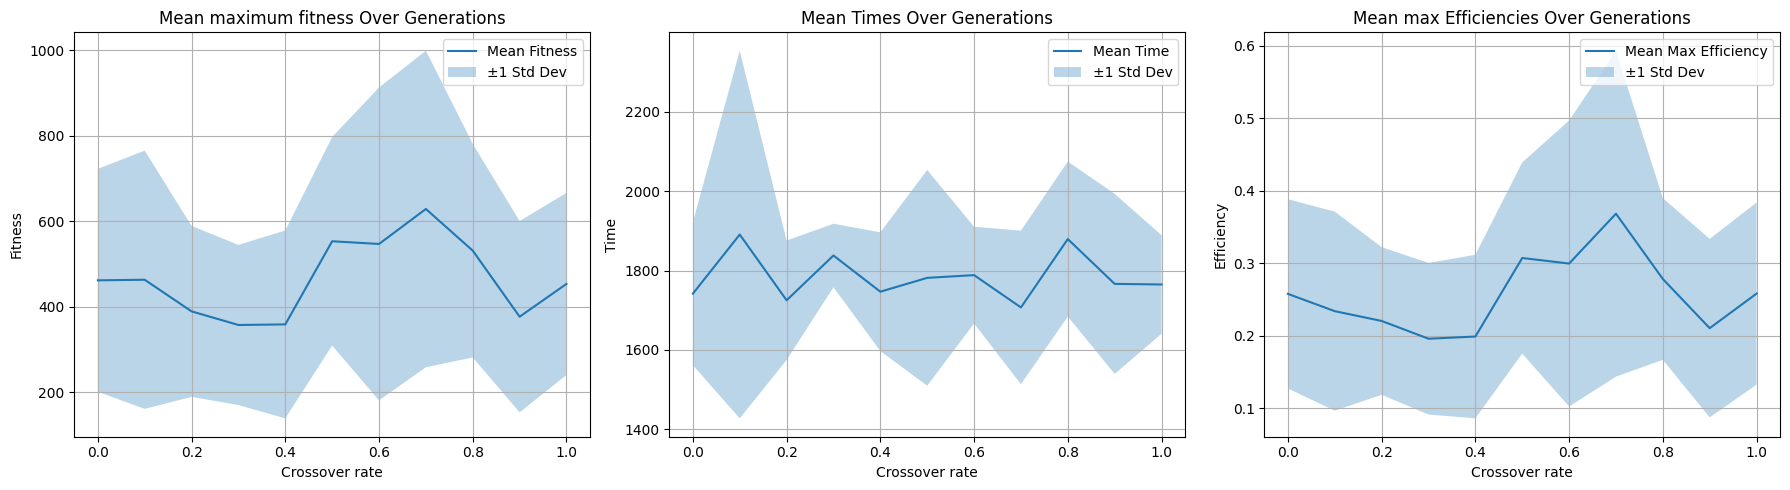

In [26]:
all_scores = []
all_times = []

all_scores.append([431.45792665501637, 713.8842891349752, 193.0589954187288, 67.74930660790517, 624.1845880348942, 811.1234126461658, 625.810720813477, 1223.8514124146468, 1099.9928990246399, 429.7234209306181, 375.3974011589121])
all_times.append([1877.482652425766, 3072.485287666321, 1754.26220536232, 1925.8800926208496, 1807.826358795166, 2353.070383787155, 1748.9379479885101, 2138.345118522644, 2298.1516468524933, 2142.7671847343445, 1903.5478951931])

all_scores.append([539.3654804808128, 208.64980554584207, 97.51194003907204, 100.73789709695109, 600.7681134971681, 726.3981249484427, 319.8218373673599, 501.0717953224355, 338.9097222164623, 768.1226738197547, 443.5487702096306])
all_times.append([2052.751387357712, 1501.0178623199463, 1453.606036901474, 1726.5596842765808, 1861.4291315078735, 2174.1797518730164, 1660.2320170402527, 1710.6132781505585, 1839.7290210723877, 1833.9110898971558, 1709.3611073493958])

all_scores.append([542.9560460153634, 405.16804236833195, 541.2864444146056, 310.0052397143339, 610.6346805187635, 628.3426081516413, 1313.109314144503, 255.29987458319334, 521.300220019797, 642.5208133762619, 699.8697844871324])
all_times.append([1728.3209500312805, 1751.6313219070435, 1658.927166223526, 1872.5704069137573, 1959.6760857105255, 1677.5815365314484, 1807.6898200511932, 1563.552909374237, 1857.3717856407166, 1984.1440575122833, 1788.5452108383179])

all_scores.append([994.6175729290405, 592.1511364977509, 744.8947775879201, 367.9766358084837, 371.17365138802074, 162.06345666396868, 898.5013709788738, 616.9623356264265, 554.197543639237, 455.7833686499372, 110.6598696627922])
all_times.append([1950.7926290035248, 1853.8209669589996, 1966.3245170116425, 1752.679522037506, 1712.9447820186615, 1656.2588486671448, 1946.3434615135193, 1862.8568363189697, 1981.5919597148895, 1376.8100159168243, 1546.7596113681793])

all_scores.append([754.9868334615828, 411.41740474360085, 397.2275000875617, 314.29394931045636, 89.05949124075522, 726.1920193241178, 346.4999690630042, 424.9011322315047, 477.0657574909685, 374.44158077992466, 279.3941002509498])
all_times.append([1735.2980003356934, 1655.9032690525055, 1761.6331996917725, 1910.52192568779, 1661.8956098556519, 1730.7896692752838, 1719.4983348846436, 1767.2027158737183, 2050.3707633018494, 1731.3665597438812, 1840.7063970565796])

all_scores.append([201.2324811435907, 16.781547465140918, 294.5802825134451, 590.45183145094, 177.50631541883467, 774.3789386509059, 193.117620208222, 577.5421885160779, 603.1674273801943, 304.3657073204042, 680.6281710002517])
all_times.append([1633.1848566532135, 1636.301215171814, 1520.4960091114044, 1713.4953782558441, 1473.5192880630493, 1528.5025219917297, 1863.6738843917847, 1542.5531389713287, 1816.2220058441162, 1795.8473048210144, 1887.609280347824])

all_scores.append([209.4228450974776, 1050.6584460983656, 237.58867954040562, 301.2353690311769, 512.8793880061289, 368.2224837608594, 574.7924664022537, 500.1444377173648, 597.2187551793791, 307.8620863796443, 512.0940064534194])
all_times.append([1429.8149156570435, 2028.7856097221375, 1762.0151154994965, 1895.003553390503, 1880.231145620346, 1680.5048396587372, 1920.9203708171844, 1735.3000972270966, 1594.952448606491, 1910.962661743164, 1691.9731817245483])

all_scores.append([239.5574757165457, 147.11671377072736, 622.5725940163146, 550.0902860651013, 138.65866580960207, 152.38171018420283, 32.25651563595105, 225.22588993243275, 491.0730523275901, 43.297936428968, 751.1881443902956])
all_times.append([1621.1309485435486, 1455.6183700561523, 1856.6892716884613, 1907.9506158828735, 1802.7763028144836, 1504.4992017745972, 1554.27965426445, 1572.1572096347809, 1737.3992557525635, 1628.757086277008, 1613.123451948166])

all_scores.append([244.71059102137133, 624.8410316862925, 376.30996198229394, 616.1162378710399, 106.02442807369422, 631.6088981227956, 619.6636953511525, 1335.0633724181869, 99.96614458887447, 66.3615355836404, 230.53683726960546])
all_times.append([1646.727291584015, 2059.761264562607, 1792.3739211559296, 1835.7024705410004, 1560.1852824687958, 1728.4865114688873, 1874.3266055583954, 1471.4500460624695, 1736.9060044288635, 1492.7277700901031, 1902.4695301055908])

efficiencies = [[score/time for score,time in zip(score_per_generation,time_per_generation)] for score_per_generation,time_per_generation in zip(scores,times)]

scores = np.array(all_scores)
times = np.array(all_times)
efficiencies = np.array(efficiencies)
crossover = np.array([i/10 for i in range(11)])

mean_scores = np.mean(scores, axis=0)
std_scores = np.std(scores, axis=0)

mean_times = np.mean(times, axis=0)
std_times = np.std(times, axis=0)

mean_eff = np.mean(efficiencies, axis=0)
std_eff = np.std(efficiencies, axis=0)


fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].plot(crossover, mean_scores, label="Mean Fitness")
axs[0].fill_between(crossover, mean_scores - std_scores, mean_scores + std_scores, 
                 alpha=0.3, label="±1 Std Dev")
axs[0].grid(True)
axs[0].set_title("Mean maximum fitness Over Generations")
axs[0].set_xlabel("Crossover rate")
axs[0].set_ylabel("Fitness")
axs[0].legend()


axs[1].plot(crossover, mean_times, label="Mean Time")
axs[1].fill_between(crossover, mean_times - std_times, mean_times + std_times, 
                 alpha=0.3, label="±1 Std Dev")
axs[1].grid(True)
axs[1].set_title("Mean Times Over Generations")
axs[1].set_xlabel("Crossover rate")
axs[1].set_ylabel("Time")
axs[1].legend()

axs[2].plot(crossover, mean_eff, label="Mean Max Efficiency")
axs[2].fill_between(crossover, mean_eff - std_eff, mean_eff + std_eff, 
                 alpha=0.3, label="±1 Std Dev")
axs[2].grid(True)
axs[2].set_title("Mean max Efficiencies Over Generations")
axs[2].set_xlabel("Crossover rate")
axs[2].set_ylabel("Efficiency")
axs[2].legend()

plt.tight_layout()
plt.show()


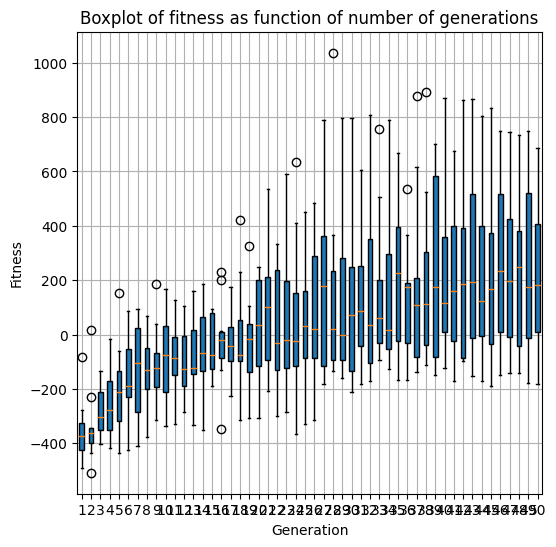

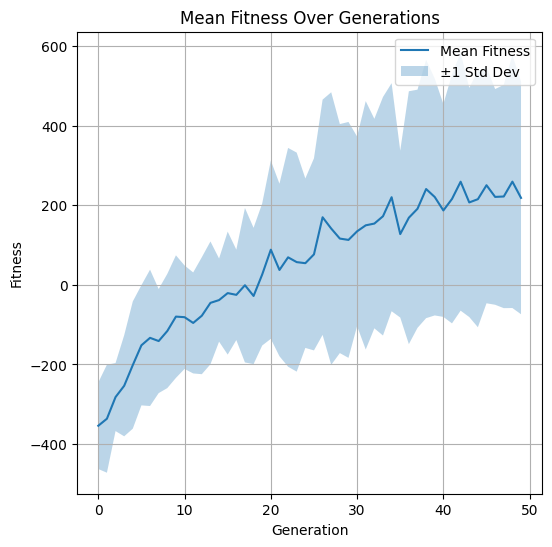

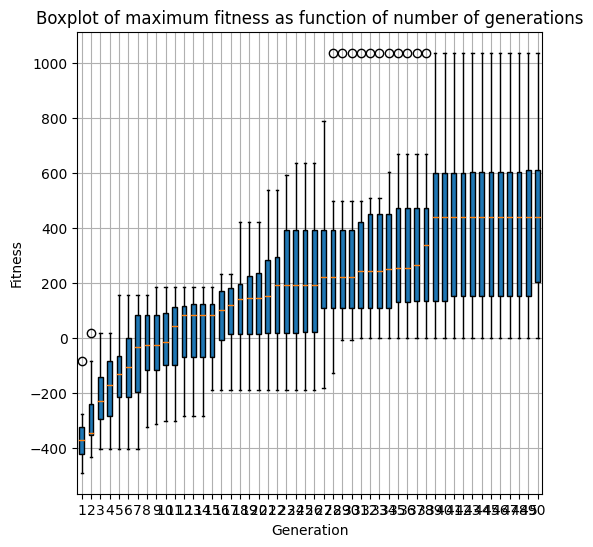

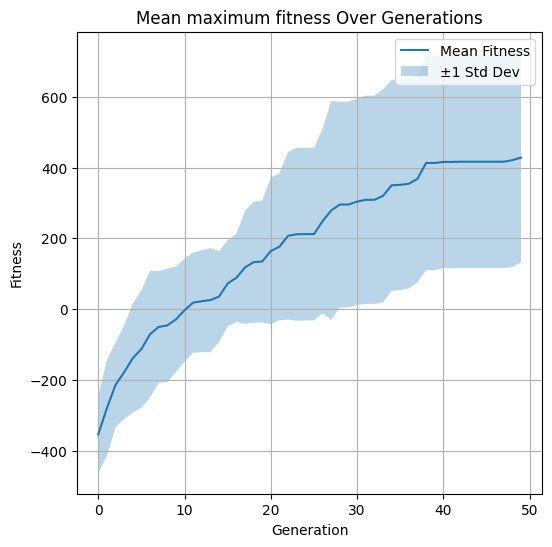

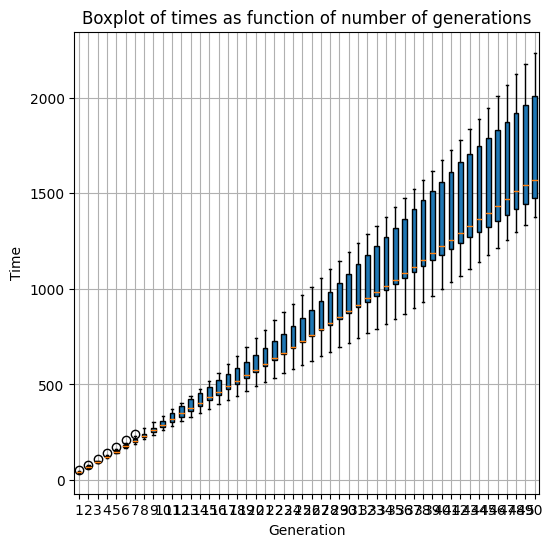

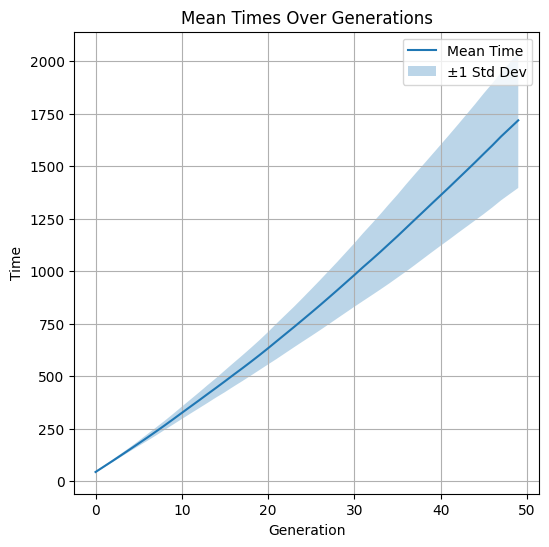

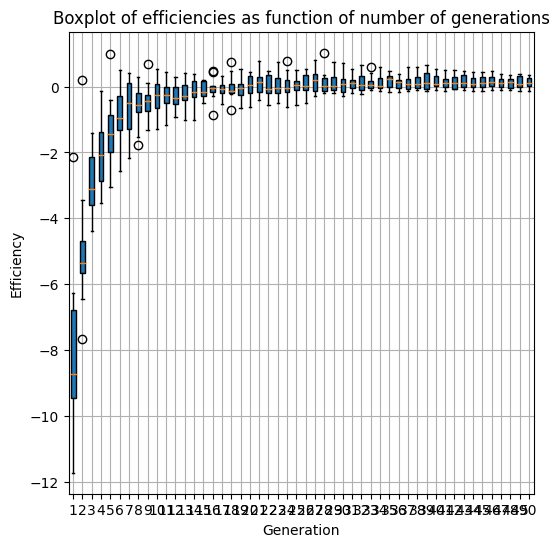

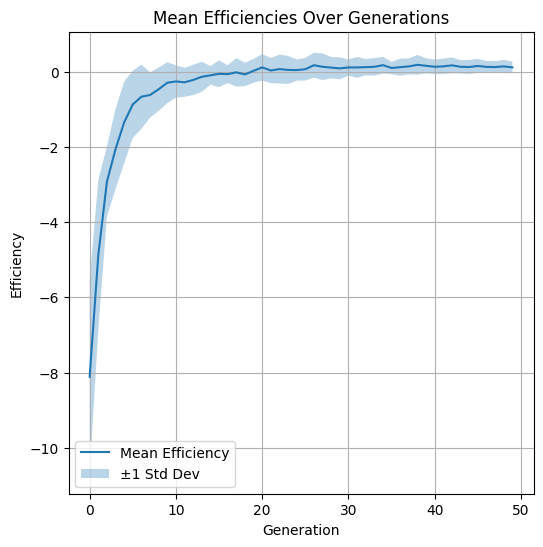

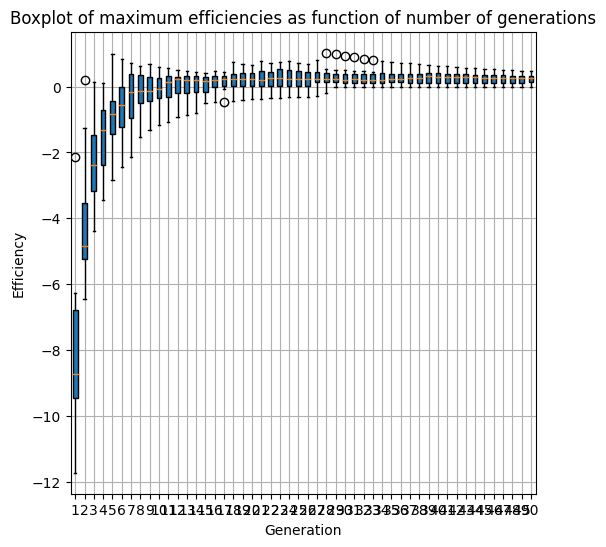

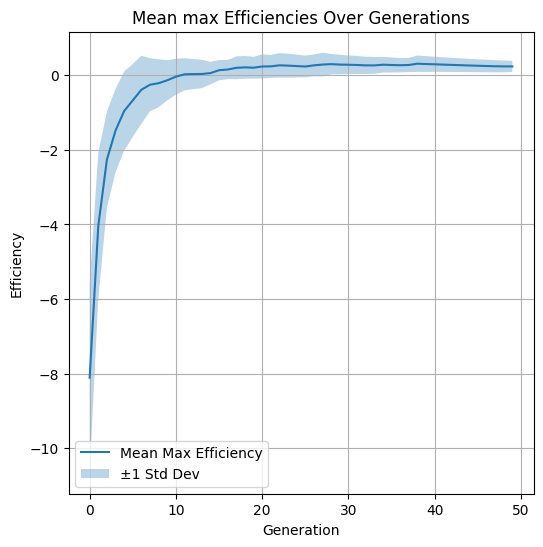

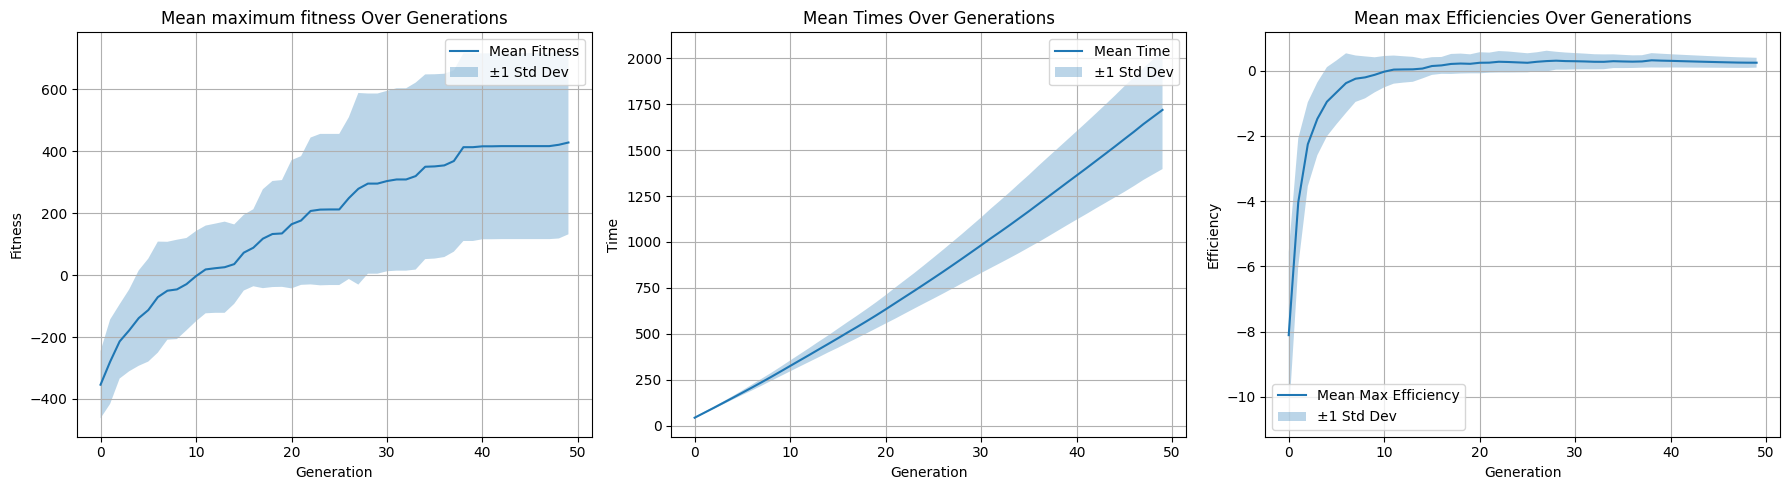

In [19]:
scores = [[-355.7480579738584, -400.06783087411543, -329.69692371121863, -408.0416953350185, -356.9062544559273, -304.41907601121216, -324.06854277155264, -375.3710747887138, -313.81168549518276, -337.24861375309126, -328.2959212985255, -284.1260676752532, -331.6707264435909, -350.557062812377, -190.1720834292891, -346.7261727380421, -226.06049428343192, -315.054873775394, -307.22725277863697, -307.38672069518236, -208.0690345782547, -299.7620477771785, -284.8785851341436, -365.2349810997568, -330.539072899458, -313.52078183111985, -183.55694294044383, -129.11251995830122, 38.17539517414038, -210.49420072557183, -102.47885984080517, -169.71064219733216, -43.62700871180118, 28.011500245055018, 178.4402991584384, 189.8170307328037, 222.1958778868514, 363.4376458843186, 634.3767975494284, 411.64071468579283, 507.0215295460628, 429.4278114196203, 520.4365381862575, 448.359558247824, 359.5218883312736, 568.9172366187286, 472.3975196877638, 396.0215420749946, 496.7752239917178, 468.6268038146042], [-393.09091978366257, -393.63090812092133, -192.9588224699499, -272.1491815874148, -116.5053631500932, -61.87518186499477, 94.99083342238988, -39.64524563506173, 37.20369320721284, 57.23085002737891, -34.62481160681918, -128.53824911795525, -128.46476795903777, 65.73668667702009, -65.49123740961772, 14.170042088250725, -88.90116434750315, 46.0955602609356, 41.20061069161423, 48.919081313821806, 121.96674103873727, 243.48837264126277, 497.66267779955695, 164.00249881214336, 136.58417720863423, 348.1679008176992, 399.4298919709072, 262.7392862728815, 344.44921378171273, 265.17348894885083, 165.72101600716417, 394.17279886129427, 214.070132303517, 294.1630247187736, 396.66681879042574, 174.84364640397445, 163.73085868858334, 119.53854378769108, 100.68301725052606, 119.10955127122537, 226.24065676390876, 245.98357699246853, 503.56926091242553, 35.81644788160794, 380.2191148506154, 223.1517403258485, 317.78756072256493, 336.04028101064347, 531.2856131741855, 153.57509907129617], [-450.2175651363625, -230.91032782964663, -133.65295627807527, -89.27725340588879, -59.02860653093195, -51.081664113819656, 70.28715612982901, -156.67851871423554, -203.6483569000764, -60.75603174259112, -64.68604266073277, -192.33358395076604, -192.95031291726588, -49.39544738836073, -98.53382177539072, 200.33589873357508, -91.04854047599093, -68.66850376153997, -62.694529641361314, 24.294721313699483, -61.93065849433397, -99.25730294819019, -171.9572158897003, -123.02818490319359, -117.87365668731199, -43.2972592502971, -150.1226154603676, -134.43882955598212, -157.97173494674394, -210.80944786137746, -182.92015496963515, -155.5487449121979, 104.82067660693883, -96.524054687546, -165.57876201642048, -139.0461238360055, -137.74010195675788, 7.13446079811952, -148.86089053487694, -122.56641013176404, -169.98443681909328, -98.48212454703554, -152.98295517266246, -171.66305163406992, -187.45868521117765, -141.12913288420194, -90.99624848245605, -138.0687057472825, -73.06010320469221, -150.38925844486778], [-82.92035427136614, -508.21588652443825, -356.35051807503214, -281.5746444920544, -179.59834921770442, 88.1022333144928, -47.69758701438994, -18.056832958002303, -60.99281635838395, 116.7544580283481, -1.4993544289013911, -13.448206275552721, 152.19406699185413, 184.78552347816319, 85.25307276111275, -4.212525174451157, 34.595923548949855, -84.07084166761689, 106.32422075327975, 112.62557527105888, 179.3231638126804, 28.12026797240614, 16.012067985028438, 6.116508091492449, 169.09950967942964, 87.95170445217616, 244.37130404769263, 117.74858558213326, -40.91885667181174, 195.63729525743634, 281.989463758035, 228.20082293278608, 166.32696961406708, 297.20834345252877, 392.85394878764146, 186.29402767576153, 110.39447144100453, 104.04146487159332, 248.71385328679, 116.64486240289432, 185.40017989243603, 127.28089878305825, 251.6551742266256, 209.46614118231759, 210.96660125782614, 245.59146526971676, 278.15343288821805, 251.64248621825413, 258.4373633424058, 220.2059875327266], [-389.8341535519369, -341.92682236352385, -269.3987880511842, -236.18892610752417, -201.05226423576917, -207.59752128653304, -83.23387938719992, -73.23429655879552, -88.87521469328819, -46.13985111925304, 128.78733354906228, -4.905727375785247, 49.57247212442596, 63.64872986429221, 61.61518256855083, -21.814695260088822, 8.011762891485041, 230.83543785612915, 35.60224021202025, 249.12183640229227, 309.83616659768745, 226.67616403143262, 117.06870048007764, 126.47458096637924, 75.34968373105563, 116.13036204729681, 281.19999158821855, 152.98562764727853, 86.83872174869131, 153.92758193580494, 126.30654277205562, 95.65433037780173, 8.040264649543367, 7.818497240118681, 273.7087104557996, 173.7794763116476, 107.49775237942214, 127.62589995487913, 486.0410342423938, 198.41438991379556, -23.85991323324651, 287.26311061148135, 136.60883248268377, 251.81891558945864, 120.95547655471042, 390.4302006472194, 92.2936649132429, 242.57038906132198, 75.14970582892309, 150.26823430802693], [-491.03573635999635, -434.0433813130971, -403.950440497591, -416.64898300540597, -435.6631628754318, -424.0977796879021, -411.6550028740002, -325.2627983095479, -314.10609372858573, -235.9675931596708, -151.4669384305303, -231.86319898508145, -147.3284967523928, -178.50316646327087, -141.42762417917663, -14.528710332214295, -103.1739237550178, -98.97068340344573, -69.77574769441091, -64.28821672402188, -104.46530344021252, -92.88078682565441, -58.97087792263427, -97.52053493859998, -9.708906592530049, -46.728471198113105, -46.109830016629616, -93.3651273766044, -51.945261955673935, -36.187679906661145, -1.5105581921694125, -71.10852655028134, -90.76293289877508, -4.6266970676365595, -15.883983954650574, -5.3001585425502356, -85.33464193929555, -55.662640137554355, -8.187096600932705, -16.094470689556484, -17.92333292887824, -91.34681212212934, -24.740631574344093, -6.099335651087166, -53.674635140260165, -10.98154291973642, -41.28499592142786, -80.55247595362658, -43.239019846934426, -36.877397342182014], [-349.5576517690823, -370.6029178081626, -302.2146518518408, -366.5191072115151, -219.2501567974077, -234.80011236922576, -262.5149482783964, -101.39366634918062, -153.25635528338873, -136.30183702217033, -104.82431725994104, -123.25829572482786, -120.16965011874328, -141.1097312535666, -134.30651719114928, -33.36646971894386, -99.33189868169426, -108.22161015700482, -160.14975065629912, -144.1959391606278, -190.31889531887185, -156.39411084909113, -112.78770324618563, -54.271530610769815, -103.89516456792624, -134.27656995747037, 111.49001611805211, -76.26205098266408, -105.60885180579672, -164.37199223852528, 49.70332952017189, -114.7027568269273, 13.919308449965769, -126.00088727309839, -131.10183970341916, -166.87830485455675, -113.15320156727664, -113.37952206550509, -116.45659354862181, -56.31445780131947, -103.77382114186636, -87.92412861368628, -103.37980520003921, 4.570360237888963, -169.03006187960528, -147.7807695640306, -140.46544119386186, -141.29063770615866, -178.00189871480595, -182.99479972757246], [-276.95407193810905, -350.46222955343535, -361.3697320165189, -147.89339395015142, -332.0385331244628, -175.10151551352317, -124.60518045745731, -190.39202094991538, -133.227929269462, -88.60500925004166, -145.15628693008767, 106.37501758066895, -87.2330273268006, -85.30850833041286, 93.08554510785211, -131.25021936380864, 15.02273238556792, -89.71697619869647, -223.1470603538193, -130.412767962903, 79.62752574681733, -140.1936598160354, -126.27414226953668, -129.1377535486275, -29.00506150408326, -99.06939892126312, -137.28748187444177, -89.71010753211495, -126.68984226416275, -11.952326193071979, -55.79389381869987, -27.01535064279551, -94.17665496444586, -70.88937234360964, -24.566079482172754, -41.35463996787344, -74.30491592865206, -56.521202923395784, -108.84494153532957, 91.98919454862036, 134.7595886264669, -85.00027140929302, 20.438834869248176, -26.784661770232532, 22.05859313578822, 65.47706830028815, 113.04708086555658, 72.9737243231087, 90.12112824276133, 207.63941372050306], [-434.48116094651465, -351.9157146142793, -167.64360455634045, -17.059971714640184, 154.15300747942703, 52.831220256992395, 50.00513998452172, 69.2967613090992, 185.5491196497815, 166.40874940514317, 92.83927907881603, 88.20330348657171, 160.74001297402137, 143.53461190248674, 92.48006563524623, 230.74878549071167, 122.62081921353057, 421.2670989488579, 32.77676546904827, 230.0124620218736, 220.31474042338135, 333.7348654284226, 224.85708520224935, 408.813640838383, 302.23707608596374, 365.2494236376257, 389.40214565839153, 366.21357520424795, 378.3411831497598, 352.7270026721632, 457.8629844170864, 509.0807013375138, 504.60526441351095, 602.6887350477107, 668.8079786837807, 366.7674148890894, 615.2131196587217, 523.2773757666743, 618.0970086782761, 594.6360161051368, 456.31179828296877, 568.6767367555639, 571.259420808469, 520.0915718980959, 633.5280037032519, 561.3666010935278, 462.18844754496087, 546.5843478711295, 684.9162861176142, 668.315122131105], [-317.46644405840107, 17.14896810162321, -303.4430539787676, -302.281671890438, -270.39437203476257, -201.21811184839484, -294.0124705119372, -202.06725620451516, -115.27700647678371, -233.94484154736568, -204.41768585543448, -174.02566702690035, -131.13764980125666, -106.48035144619598, -85.86787448252207, -101.38954313979504, 176.34715712296065, 56.28553800166377, 327.2570629262084, 241.2859550721398, 536.5071930040964, 329.6643129366164, 590.3291929838094, 634.1631783481049, 451.39825708164653, 484.8924971877949, 788.9125985926975, 1036.89928980809, 797.2607460733107, 794.9244835535474, 605.579907509768, 806.0153658290708, 756.0338627986094, 791.0949581643326, 627.9791783065983, 535.99766967448, 878.1850398878754, 891.3031019526233, 701.2071666812734, 869.2156285386259, 674.7283183868655, 862.1906940851187, 868.3419389115245, 804.8180372786999, 834.814039593592, 747.5403578634564, 745.9832432743199, 733.7159942945457, 750.5158096304381, 685.860195309754]]
times = [[44.715532302856445, 69.84692192077637, 95.34247660636902, 119.30964279174805, 143.02177500724792, 166.40703225135803, 189.64714670181274, 213.3435025215149, 237.58136749267578, 260.8017976284027, 283.4280745983124, 306.7750754356384, 328.5206210613251, 350.6067934036255, 373.6154625415802, 395.85152649879456, 418.41400623321533, 441.2561299800873, 465.27485489845276, 490.0231854915619, 513.1461193561554, 535.2498366832733, 557.9163889884949, 579.6712281703949, 601.7999987602234, 624.3892223834991, 647.1470685005188, 671.795223236084, 696.5406777858734, 719.343154668808, 743.9604341983795, 768.5464997291565, 791.0171527862549, 815.8065369129181, 841.8521537780762, 869.7907378673553, 898.9417836666107, 930.8175101280212, 964.8956241607666, 1000.9076058864594, 1034.1167588233948, 1067.8138978481293, 1103.9040489196777, 1139.762760400772, 1177.0392370224, 1215.8752210140228, 1256.1035103797913, 1295.226021528244, 1335.347711801529, 1373.6017527580261], [43.49378204345703, 71.33094811439514, 98.50778889656067, 131.49112200737, 160.96455931663513, 195.21397233009338, 230.88438391685486, 265.8537814617157, 301.0573673248291, 336.03776144981384, 370.5912253856659, 405.39267802238464, 439.695170879364, 472.66396594047546, 504.23714566230774, 538.8633751869202, 570.3002564907074, 600.7544131278992, 632.3507280349731, 663.3067512512207, 695.187579870224, 728.1109485626221, 761.9639084339142, 795.0488374233246, 828.4504940509796, 862.5363981723785, 899.3632147312164, 933.303065776825, 967.5113623142242, 1002.8961334228516, 1035.5268211364746, 1070.7490305900574, 1104.5104792118073, 1134.9411265850067, 1170.8151428699493, 1205.1156129837036, 1236.6567571163177, 1268.072894334793, 1299.2995693683624, 1333.19721865654, 1368.2620570659637, 1402.877477645874, 1436.749838590622, 1471.5134296417236, 1506.233645439148, 1540.399359703064, 1575.7232913970947, 1612.571689605713, 1650.380773305893, 1687.1765484809875], [42.55987477302551, 67.24213314056396, 94.90470457077026, 121.34852457046509, 149.33752584457397, 175.31228971481323, 201.08637928962708, 229.02354335784912, 257.3553524017334, 285.85781478881836, 314.2629146575928, 342.6394307613373, 369.817923784256, 397.7307708263397, 425.26030349731445, 452.42813181877136, 480.5817129611969, 507.9799211025238, 535.9531137943268, 567.0223519802094, 597.7052271366119, 628.7648506164551, 660.2907040119171, 694.0084247589111, 727.0900592803955, 757.93310546875, 791.6870081424713, 825.0443322658539, 858.8681480884552, 895.0522172451019, 930.4219348430634, 965.2971229553223, 999.7755355834961, 1033.6374156475067, 1068.2252893447876, 1100.9348530769348, 1135.9602766036987, 1171.988596200943, 1208.1539931297302, 1245.1572926044464, 1280.2949705123901, 1314.782791852951, 1349.538932800293, 1383.5697383880615, 1417.7895827293396, 1451.2151346206665, 1484.9918048381805, 1535.0942378044128, 1558.3480231761932, 1582.5131950378418], [38.65518498420715, 66.36145615577698, 92.81508827209473, 119.9767758846283, 146.89578652381897, 176.6317479610443, 204.7333583831787, 233.8884255886078, 269.69892477989197, 310.0816831588745, 353.07977628707886, 392.65307879447937, 433.38691997528076, 476.20829486846924, 516.8862881660461, 562.1795961856842, 607.2019627094269, 651.335024356842, 695.6634340286255, 741.2757115364075, 786.796927690506, 836.0301513671875, 879.6394047737122, 922.2521896362305, 966.893235206604, 1011.281325340271, 1057.1243071556091, 1103.6983528137207, 1146.792861700058, 1194.007969379425, 1238.1297035217285, 1285.361174583435, 1330.1659350395203, 1378.0929844379425, 1426.699577331543, 1473.241759777069, 1521.983003616333, 1567.9157755374908, 1613.6422233581543, 1658.5529997348785, 1702.8711698055267, 1747.0661244392395, 1793.2006878852844, 1838.579339504242, 1882.0695216655731, 1928.184841632843, 1973.486525297165, 2022.3615729808807, 2067.283572912216, 2112.343355178833], [40.70062708854675, 64.74894618988037, 90.58176064491272, 116.66322636604309, 143.18698716163635, 170.03475952148438, 195.29323601722717, 221.11356210708618, 246.60637044906616, 273.7336642742157, 299.1807761192322, 327.00944995880127, 356.0625710487366, 384.7023491859436, 414.1010091304779, 442.2269790172577, 473.5644907951355, 502.7354984283447, 533.989440202713, 563.991156578064, 595.8630323410034, 627.0553252696991, 659.5963404178619, 690.9140558242798, 723.1204786300659, 753.5691158771515, 783.6666119098663, 813.6674783229828, 844.1155786514282, 874.4610884189606, 902.4800570011139, 931.4908196926117, 961.8815319538116, 992.8674411773682, 1024.607901096344, 1054.9473118782043, 1087.5729274749756, 1119.5110177993774, 1152.612764596939, 1185.2016942501068, 1215.631139755249, 1247.283409833908, 1279.3984608650208, 1310.4631447792053, 1343.6118779182434, 1377.744116306305, 1411.7331249713898, 1445.0693335533142, 1476.4029009342194, 1510.7904787063599], [41.869739294052124, 67.26116108894348, 92.17642951011658, 117.4009337425232, 142.37454223632812, 165.68676209449768, 189.503981590271, 213.9585108757019, 239.02535009384155, 263.0633330345154, 288.2741425037384, 313.8826377391815, 339.59179186820984, 364.58369159698486, 390.86257314682007, 415.7456166744232, 442.9753575325012, 469.08913135528564, 495.9825222492218, 522.7693734169006, 549.8325057029724, 576.6413233280182, 604.6921553611755, 632.7619225978851, 659.2909548282623, 687.4329435825348, 716.1938724517822, 746.8305957317352, 778.0035464763641, 809.0999140739441, 840.4942893981934, 872.156252861023, 902.8172955513, 934.3567979335785, 964.3720586299896, 996.5872206687927, 1027.1009130477905, 1059.9107947349548, 1091.8087105751038, 1122.4550030231476, 1154.6738803386688, 1184.2952361106873, 1215.4283485412598, 1247.5064735412598, 1279.158684015274, 1310.169808626175, 1340.6703622341156, 1372.232797384262, 1402.8704626560211, 1434.467477798462], [41.44054126739502, 68.54953622817993, 93.47947454452515, 121.07105851173401, 149.21193599700928, 175.16196084022522, 201.65937113761902, 230.5227494239807, 258.92345118522644, 287.5720856189728, 316.7830080986023, 345.3344075679779, 374.0084865093231, 404.4207158088684, 433.749862909317, 461.3092432022095, 491.63747549057007, 521.3423321247101, 549.4477725028992, 579.3324427604675, 607.7912354469299, 637.601612329483, 667.3875200748444, 697.265866279602, 727.030876159668, 754.5139315128326, 782.6925559043884, 812.3933217525482, 842.6648037433624, 873.4443371295929, 904.5585362911224, 933.7099242210388, 964.1399748325348, 994.6643967628479, 1025.2434434890747, 1055.2289671897888, 1085.8206508159637, 1117.4989743232727, 1148.1112802028656, 1176.9169461727142, 1206.8716247081757, 1235.9509830474854, 1265.3764255046844, 1292.3953759670258, 1318.7239272594452, 1346.7324702739716, 1376.331069469452, 1406.194657087326, 1436.0447845458984, 1464.5545139312744], [43.300665855407715, 71.19555306434631, 98.83286118507385, 126.31871342658997, 154.26381468772888, 181.431499004364, 209.99699926376343, 238.15364384651184, 266.02235102653503, 293.92647409439087, 323.35073041915894, 351.50904726982117, 378.6846387386322, 406.544979095459, 433.9489231109619, 462.4526708126068, 491.4951572418213, 519.8751220703125, 548.4432878494263, 576.3543374538422, 605.5697572231293, 635.5265917778015, 666.3854644298553, 696.2328820228577, 726.1982111930847, 756.15758061409, 786.3917608261108, 815.465539932251, 845.1805851459503, 875.4525125026703, 905.9133095741272, 934.8537693023682, 963.6809363365173, 993.7390902042389, 1024.4670391082764, 1060.499694108963, 1095.1863775253296, 1130.5255017280579, 1165.7224094867706, 1200.4647195339203, 1235.3216805458069, 1270.7696597576141, 1308.4266300201416, 1345.331417798996, 1380.3592548370361, 1416.4297127723694, 1454.1784768104553, 1489.2956721782684, 1524.2546396255493, 1558.5998125076294], [48.30564737319946, 76.60525751113892, 102.0627281665802, 127.6997709274292, 155.59773921966553, 184.3334836959839, 214.44946360588074, 244.54902172088623, 274.048330783844, 304.59453296661377, 336.26553869247437, 367.245157957077, 398.56236720085144, 431.25090169906616, 465.12683367729187, 498.5104937553406, 533.2081391811371, 566.4819440841675, 603.759880065918, 640.7316646575928, 679.8145899772644, 722.4657592773438, 763.5321805477142, 806.9789981842041, 853.2140207290649, 901.8103077411652, 951.2738060951233, 1002.2013783454895, 1052.8486638069153, 1105.7930688858032, 1158.1544959545135, 1215.4283711910248, 1268.4884231090546, 1322.6407639980316, 1380.8733224868774, 1435.6194713115692, 1497.025042772293, 1555.8825981616974, 1614.8041362762451, 1672.2289943695068, 1725.744470357895, 1779.6137433052063, 1833.4666230678558, 1888.2993385791779, 1946.0105555057526, 2003.1059575080872, 2058.5170035362244, 2118.892711877823, 2177.1784479618073, 2234.8966982364655], [50.673720359802246, 80.13418841362, 112.17737102508545, 143.27749681472778, 174.68419480323792, 207.42013788223267, 239.84412837028503, 272.30730652809143, 303.1781837940216, 335.5493047237396, 367.189404964447, 399.8533673286438, 432.1133916378021, 465.5862898826599, 496.7528302669525, 529.3554253578186, 560.2579836845398, 592.3187139034271, 624.4838571548462, 659.4511585235596, 700.9251484870911, 742.8596651554108, 784.8930819034576, 826.2901060581207, 870.8178691864014, 918.2748265266418, 960.6191608905792, 1007.9456171989441, 1058.738382101059, 1106.3055036067963, 1160.3041195869446, 1216.2783501148224, 1265.338814496994, 1317.75470495224, 1369.1046624183655, 1421.3202452659607, 1477.3037359714508, 1531.6902277469635, 1582.6064229011536, 1637.287315607071, 1695.1886656284332, 1755.0605919361115, 1815.3910303115845, 1878.1203796863556, 1940.9430420398712, 2008.2924914360046, 2066.5435342788696, 2121.040283203125, 2175.548998117447, 2231.5673353672028]]

scores2 = [[-225.7480328873372, -322.24391713767045, -24.84078375641414, -96.19301332974808, -84.67046746213663, 116.29323373508366, -24.90883348775408, 190.89409795341635, 190.5236520315899, 92.97672046503041, 112.07078725073536, 184.96237777789156, 128.60397524310815, 212.7712799722234, 330.71762429282563, 73.77833840462081, 71.10213132454504, 89.67853691379412, 397.66347647839206, 303.27140249280797, 329.8398535714793, 231.77667557305665, 217.98518907224877, 257.10891966018846, 330.2204453208815, 186.42380012670975, 225.86893906547448, 160.8492736740596, 233.36648316516144, 313.1308194612111, 367.79364208407185, 301.7118270502675, 263.7699695853075, 254.2012827742185, 356.20957330854253, 185.13829531321005, 101.33419424072082, 143.34182464492335, 203.47883858359225, 160.2555731840431, 328.1660626033765, 242.26099571198554, 277.6596736828921, 200.05288750991403, 333.9426372023344, 301.9815415902245, 298.5842199069381, 176.43710840437774, 166.93404735572372, 300.15075005700396], [-250.096005355722, -78.19553801806863, -7.742517032014685, 109.34307252458318, 274.00305241480663, 70.37371317328585, 249.70108900889514, 74.31582278950354, 149.09898679470118, 177.5203426778544, 47.41672668810422, 108.08882770889429, 232.24264630978354, 184.16891856805864, 52.30379472600831, 164.68579973146416, 85.28868046942263, 196.83835151467133, 96.88596023659001, 105.6404528783801, 114.38513155704317, 203.1296575656316, 24.163003197192026, 72.30688462118184, 133.45367228737982, 126.31799252745046, 77.68747968093312, 129.89441798736334, 67.0751422618187, 164.29555324898087, 73.9023564082833, 223.78107866233506, 170.82281678900887, 232.25071320481612, 161.85662237027537, 133.61657327549875, 241.22768401180826, 159.67384201269897, 96.5854588691694, 95.01045024271967, 220.1839255724932, 159.55602582107574, 201.23762967263994, 127.31921899387493, 102.88229739003538, 70.64679230083138, 186.68946165077506, 179.03727743925302, 227.33397386242402, 101.37352391305157], [-261.7058436409696, -215.02839685232482, -127.00376144101782, -8.153894772916914, -231.88826624368764, -187.95345967966102, -220.61454096722645, -243.69933919395206, -226.10389280253273, -208.98426736100058, -258.7101285122918, -257.5670646847171, -262.8329846438602, -254.95925844833815, -227.42393091358437, -177.1581510526644, -218.8251262830484, -231.30851082255788, -222.04349800974023, -210.8324165809812, -229.24046147828278, -260.8717933908937, -212.11620027157517, -237.41107697137178, -224.53578306716298, -204.3428850100136, -224.35482462556388, -248.17706366312945, -219.94246742372965, -273.38271129935583, -222.22887545183886, -246.78651362887604, -248.69056377581774, -197.2143567345442, -227.38912904896694, -256.35768102646784, -255.8080790000602, -253.53884620817684, -228.65148604435765, -232.13901148564594, -232.65338220289698, -238.27951278457942, -264.02872994491645, -207.73085493075257, -251.1588700263523, -264.89586922149164, -227.63588503332537, -206.8025651568264, -218.5120337225966, -243.75609057754997], [-255.34138532520367, -401.313586432272, -355.6034721145418, -335.487646186671, -119.58889027859288, -216.40852229781615, 79.05629052635828, -97.5047456114439, -13.300876524793779, -116.85350815198127, 108.12550485586505, 26.827523324426494, -119.60586777351763, 57.743072829334395, 49.817550461990976, -53.45506781016705, 50.22191714105594, 27.380435508795504, 133.22748702346613, -1.030254813089492, 199.18384977777856, 180.8693459720669, 160.3805107628341, 126.4471963165114, 92.62278910079225, -50.86622019257122, 126.29340555805977, 281.681313588233, 155.8184010857314, 186.3585031722589, 375.1748327119689, 233.26042632916074, 323.2801443979589, 417.33533659566604, 410.39985232834727, 407.7300297367781, 248.79955813073997, 326.7648040272823, 281.09284147953514, 278.3978317747337, 244.23082656330507, 189.2668089499, 498.22668888657404, 260.7487182763991, 365.7986600259862, 259.4305592280805, 298.8279361986438, 375.29821565279894, 305.1041414127415, 369.84553403422694], [-440.6240142050692, -112.98314182553386, -275.5127006577601, -103.14597554266186, -185.7748203287968, -83.50621655125315, 160.1247667787793, 73.20716309830236, -137.32514313601354, -160.411495597343, -172.30174119521428, -200.95155681394493, -230.22495559518984, -30.47332688530517, -174.17410294107543, -152.7433071030436, -215.21029650893166, -189.02459277463169, -49.91075810796582, -72.23525039557273, -122.42265892063237, -172.8009894698271, 97.01752268531388, -130.10835847461084, -138.6284763106944, -102.63092727387244, -141.47711363210936, -124.1390309946975, -158.8221197234633, -192.5716835330609, -154.9147014839648, -152.04017598388756, -61.29010507512027, 6.597182919437188, -184.41801122752247, -163.41603276720062, -213.74687149416116, 104.47718279244776, -70.43913260166656, 38.93226524922849, -140.2416411321151, -155.7342781378839, -147.15088094121188, -58.51880507273321, -136.43328428940097, -192.12109496194375, -134.04953465620497, -107.32083201224754, -145.97730533869998, -129.80908134397947], [-381.5500675412259, -326.83198336983475, -415.57315291958423, -399.9371934474412, -337.5638124894532, -187.66342512242724, -242.90147892698667, -58.458125146075616, 128.3952403456148, -21.123301918262385, -7.505944352106823, 113.08657275199806, -24.09223724077404, -25.292079836119512, 111.82451450785655, 229.41204171242896, 122.98966707994094, 225.8077647110744, 102.5178412938931, 280.0572224609266, 244.04246073691195, 269.4053172133166, 202.30907139581953, 251.58344890604047, 328.2502825068433, 234.79785357066152, 348.2929417351303, 517.2851285176732, 424.68008324504797, 422.3302529689964, 305.9596202813321, 623.509438388949, 517.8835958635937, 525.2287240195114, 391.2353221480091, 465.0503954980899, 289.37782343299784, 579.0093323506123, 462.51498886858104, 420.3522663926949, 377.3730178037489, 676.0299786961855, 278.07680150131057, 497.41361133276916, 490.7300064597306, 360.56137454897436, 472.47809263285177, 428.77935996175984, 608.7289449817171, 421.77065876269705], [-339.59139970767285, -312.253828556955, -304.319915258307, -166.42349520893106, -303.9983071282443, -217.55026885707252, -309.924605171142, -127.7326314793026, -39.49711096757017, 132.44844697778512, -85.5604454225961, 19.00865840831421, 40.00461785911904, 270.6247854264299, 180.5603215696903, 225.4702600781864, 300.0128627289752, 122.56724695960847, 218.363505407411, 200.20785946700838, 146.33507310075683, 410.29238336812364, 241.31417491399054, 269.3727134258256, 196.212882038705, 272.8611150149968, 176.0204423991458, 251.8158239969305, 244.07459002410587, 268.30595091092187, 221.42939633281057, 233.98393248882593, 295.25473942873015, 270.58618871823785, 408.8062232440143, 473.352695311669, 416.87962963508386, 323.5616684837123, 556.7295615595042, 587.8498547869443, 552.5040288005953, 298.09800412251417, 378.323011415683, 306.5530324754477, 419.16689165801745, 238.92643855140747, 347.273988890887, 414.8006286708219, 346.95920614771063, 491.8852542476573], [-477.40506218375333, -185.17659542925833, -202.43391867216923, -145.7210639864411, -28.1096318484377, 174.14717833707186, 332.91684356044294, 409.51153004441085, 562.8886270661068, 544.0445914621127, 606.2790458957006, 458.9080629778968, 648.3705795223846, 549.2983903765928, 660.8730305213171, 735.1194709839667, 781.1859590733511, 807.5962890865299, 693.433012065792, 853.5496207733806, 728.8416326202494, 777.7432905558665, 904.4240114739098, 962.9552421737194, 917.634116689627, 894.3286404825393, 896.7085840266585, 615.9843075208244, 714.9579786511678, 825.6920142939085, 869.2129825284759, 1114.9679803470835, 858.2134932770628, 768.9506476369706, 1068.2984524805665, 1165.8242960539737, 924.388692587233, 866.0605493186209, 943.3074069201114, 814.8470994999111, 996.6212824775822, 1061.7351152391325, 723.2422355121902, 1147.544379989768, 865.315820675374, 861.7616449686032, 922.7475547613554, 875.469775318986, 787.8751727179103, 1124.9849859623803], [-196.30211805413808, -243.48158530754637, -138.90050450778543, -256.1704155684904, -243.33844568031424, -104.35336499907338, -234.57975120041095, -286.67003768708565, -243.06970788830068, -278.1940123689097, -169.15057964050845, -120.12598988110447, 100.84622375127888, -36.77070363001009, 102.8313637073722, 141.62456108737527, 218.95202288851277, 362.16579187560035, 375.3332215645552, 177.99854324144349, 307.1997491703643, 286.1519402437239, 179.32043980094573, 307.65856540186564, 141.21799762980993, 250.69337207418548, 292.1972866341159, 214.51583229258586, 191.00612525398043, 252.09055594042437, 268.06718537225976, 206.22399099031944, 452.2677162123421, 267.4640292973489, 388.686456240026, 256.5744926260405, 291.98266639149466, 184.45647598956344, 655.4315800396562, 480.07370744153, 332.68291260675426, 231.73627758382202, 353.2689761194387, 210.65136830572249, 264.1564601648622, 326.7201275708218, 262.65936405101024, 329.7246313779953, 330.05537766812864, 568.8390839701832], [-426.14780575378086, -427.5367586121454, -214.56616418218132, -214.89750094327133, -57.206860126489644, -160.11752719374513, -105.71765165241035, -106.62994095608596, -167.56232076101134, -60.796043756097276, 9.095027702086412, -123.6571749436348, -45.779185059919605, -95.16006409446342, 2.8975287451420755, -9.543512764836322, -22.538139100950644, -48.5743795768631, -36.00224730558814, -75.78534194200317, 163.6612881685783, 209.23290981649382, 98.20489338228592, 203.3401387548597, 186.86982882588572, 302.27405620735914, 279.64527340171054, 236.2333686859518, 278.84128542983336, 477.10402460709247, 264.152602943181, 196.91646362652958, 356.64631950437604, 264.0094762664704, 340.4986059491307, 445.6701059621232, 417.9043985788128, 361.4627822517473, 405.06776674388607, 345.49791610481856, 466.2479473083506, 590.4584697236293, 401.62698491776683, 453.01568129456376, 307.77251596511525, 385.17200736775004, 526.6811042938264, 462.67686055451486, 484.9115580277909, 604.9208551956972]]
times2 = [[91.38423299789429, 152.29203343391418, 218.34212160110474, 284.7124991416931, 349.92021107673645, 417.95065665245056, 488.29674887657166, 560.2130918502808, 635.4477558135986, 712.401731967926, 790.5483756065369, 868.5901508331299, 943.5693759918213, 1018.7146897315979, 1097.313212633133, 1174.234071969986, 1253.3851997852325, 1333.5250391960144, 1413.548655986786, 1494.9725563526154, 1577.8857777118683, 1663.5564782619476, 1746.5420186519623, 1833.9350650310516, 1922.3495795726776, 2011.5197677612305, 2102.059766292572, 2192.6073439121246, 2281.631726503372, 2367.062545776367, 2453.2832045555115, 2539.5645570755005, 2623.87992143631, 2708.6137449741364, 2793.79119181633, 2878.056740760803, 2964.036913394928, 3046.075008392334, 3131.493894338608, 3211.3979482650757, 3290.279363155365, 3368.316149711609, 3447.0428960323334, 3527.4822914600372, 3606.3912858963013, 3687.454102039337, 3766.064851284027, 3842.6528379917145, 3920.317453145981, 3998.0431632995605], [79.27942752838135, 134.38902473449707, 189.4001545906067, 245.333731174469, 303.61199164390564, 360.8083264827728, 418.09917545318604, 475.6767168045044, 537.7790911197662, 596.8146159648895, 654.6793177127838, 713.5953936576843, 772.502090215683, 832.9655439853668, 892.6484155654907, 952.6715030670166, 1009.976301908493, 1070.755565404892, 1132.1105408668518, 1192.3663351535797, 1254.0220668315887, 1315.5885660648346, 1376.8583834171295, 1438.0917928218842, 1500.0314455032349, 1564.2988576889038, 1629.655291557312, 1696.0386564731598, 1762.3918941020966, 1832.3964734077454, 1899.649832725525, 1972.1169407367706, 2043.6767172813416, 2116.134331226349, 2188.243881702423, 2259.6974976062775, 2334.068470478058, 2407.3031656742096, 2480.505363225937, 2550.954729318619, 2623.5831921100616, 2694.6080043315887, 2769.617159128189, 2843.544903278351, 2917.1970841884613, 2991.2658739089966, 3064.257563829422, 3137.546834230423, 3210.7161934375763, 3283.226265668869], [75.63329291343689, 130.06498312950134, 186.55108046531677, 241.56194972991943, 297.9076633453369, 356.5109543800354, 412.8454239368439, 472.06296396255493, 530.7991383075714, 589.2831838130951, 646.3648357391357, 705.4213206768036, 762.6032354831696, 821.7657287120819, 880.0358700752258, 938.4809641838074, 996.740532875061, 1055.1925015449524, 1113.7141728401184, 1171.4873638153076, 1231.0633647441864, 1288.9560089111328, 1347.8969683647156, 1406.3672015666962, 1464.024713754654, 1523.5853950977325, 1582.05082321167, 1639.7149085998535, 1699.4125378131866, 1756.894799232483, 1816.3356313705444, 1874.8981504440308, 1933.6229934692383, 1991.3413181304932, 2050.78897857666, 2108.128741502762, 2168.1302428245544, 2225.3953824043274, 2284.1840085983276, 2342.893517971039, 2401.6121180057526, 2460.16349029541, 2519.893861055374, 2578.200761795044, 2636.415867328644, 2695.335476398468, 2754.37561750412, 2813.0504615306854, 2872.684848546982, 2931.7226917743683], [80.47215175628662, 134.19680047035217, 186.4970359802246, 239.67873239517212, 294.27373695373535, 345.98370361328125, 398.1734986305237, 445.57561683654785, 492.4377009868622, 539.2526829242706, 587.6563057899475, 635.5423457622528, 682.7744765281677, 732.8038418292999, 781.0714979171753, 832.3591763973236, 885.0761351585388, 938.156040430069, 993.2290849685669, 1051.3749146461487, 1109.059097290039, 1168.520976305008, 1230.8973853588104, 1295.09517121315, 1361.6085171699524, 1429.8220579624176, 1499.1353197097778, 1567.8716502189636, 1640.4055371284485, 1712.4182541370392, 1787.0414531230927, 1864.1275141239166, 1942.231969833374, 2023.021232366562, 2106.6612944602966, 2186.0097794532776, 2266.2701127529144, 2347.644395828247, 2432.168473958969, 2519.511900663376, 2609.305643796921, 2697.050350666046, 2783.222976922989, 2867.7617189884186, 2948.754936695099, 3034.3111748695374, 3118.5287070274353, 3207.9074709415436, 3293.6945927143097, 3386.1679213047028], [77.8294575214386, 128.80191135406494, 180.62931370735168, 233.7021815776825, 287.9894595146179, 343.1833076477051, 400.0938322544098, 454.875070810318, 507.7009036540985, 561.1938378810883, 612.2290380001068, 662.4179518222809, 715.1289629936218, 769.3788857460022, 825.2276055812836, 880.5186007022858, 936.87033867836, 995.2796902656555, 1054.0702414512634, 1113.030421257019, 1173.7394289970398, 1234.6076669692993, 1294.8888506889343, 1353.080802679062, 1410.8083319664001, 1469.3312208652496, 1527.4628822803497, 1587.4146637916565, 1645.8589043617249, 1704.9856185913086, 1763.0652832984924, 1818.170083284378, 1873.3925831317902, 1926.7733283042908, 1979.8924939632416, 2032.5602400302887, 2086.7805004119873, 2139.528583049774, 2194.7796404361725, 2247.9113569259644, 2303.0870440006256, 2354.8294281959534, 2407.00390958786, 2457.1968586444855, 2510.179148197174, 2563.7707755565643, 2614.798988342285, 2665.963948726654, 2717.174123287201, 2769.787821292877], [72.19246220588684, 121.61871647834778, 169.67386937141418, 220.4664170742035, 269.9503390789032, 318.2871241569519, 368.24831891059875, 422.75092935562134, 478.287410736084, 535.0965378284454, 593.5125451087952, 651.8268694877625, 710.9990971088409, 773.2373201847076, 832.3539996147156, 894.3008167743683, 953.616194486618, 1015.582845211029, 1078.6633100509644, 1142.1301310062408, 1208.7313148975372, 1280.1539206504822, 1354.3130733966827, 1426.7185611724854, 1500.4702723026276, 1575.6170942783356, 1652.3663108348846, 1726.5036778450012, 1799.8595345020294, 1872.9279186725616, 1947.3819406032562, 2020.242154121399, 2096.6230556964874, 2173.67565202713, 2248.8548622131348, 2329.200623512268, 2408.0261075496674, 2489.477826833725, 2568.8924696445465, 2651.082726955414, 2732.875369310379, 2814.4599692821503, 2893.0034816265106, 2970.7695224285126, 3046.6277174949646, 3123.651034593582, 3198.1365303993225, 3275.3695180416107, 3353.275539636612, 3431.137385368347], [79.06800627708435, 135.42796230316162, 189.51135110855103, 245.45253252983093, 296.5413613319397, 347.973819732666, 398.75334310531616, 449.0411388874054, 499.6317870616913, 551.9477052688599, 604.0647292137146, 655.9124104976654, 708.9452805519104, 768.0106363296509, 828.9099082946777, 891.9971780776978, 955.0016086101532, 1018.5004901885986, 1082.0757927894592, 1146.4239201545715, 1209.7893629074097, 1275.1298401355743, 1339.8937182426453, 1405.8093905448914, 1469.9324443340302, 1535.6825704574585, 1599.9416863918304, 1665.8106536865234, 1731.6997594833374, 1799.783394575119, 1866.4784898757935, 1934.1946847438812, 2004.1229705810547, 2073.595554113388, 2145.1454536914825, 2216.342252969742, 2289.002563238144, 2359.873481988907, 2433.3281650543213, 2503.1529924869537, 2575.6387042999268, 2646.0931100845337, 2715.7828707695007, 2784.9165761470795, 2855.4174473285675, 2925.751209497452, 2997.885187149048, 3070.2295129299164, 3141.73002243042, 3211.1802954673767], [78.15777158737183, 136.73725128173828, 188.1839644908905, 234.73679971694946, 275.4959394931793, 315.80931782722473, 357.20975518226624, 399.3269453048706, 441.4513599872589, 486.58279156684875, 532.2359600067139, 579.1987750530243, 632.6249666213989, 687.2772102355957, 739.9451022148132, 796.0418119430542, 852.1864666938782, 907.6964974403381, 966.1816642284393, 1026.7201764583588, 1086.4988350868225, 1148.0217599868774, 1207.7425692081451, 1269.9336459636688, 1330.3971645832062, 1392.7573790550232, 1451.925856590271, 1513.1159925460815, 1575.0797698497772, 1636.469173192978, 1695.7210507392883, 1756.4568464756012, 1818.7886221408844, 1882.5768954753876, 1945.8517122268677, 2010.1350755691528, 2077.9249873161316, 2140.631703853607, 2206.9982056617737, 2273.7098541259766, 2339.9832293987274, 2405.548273563385, 2472.16135764122, 2539.913100004196, 2606.898917913437, 2677.5225903987885, 2746.320793390274, 2815.0562920570374, 2884.165608406067, 2953.070811510086], [77.61456346511841, 132.34274744987488, 191.23042702674866, 251.6364209651947, 309.5289707183838, 368.5685787200928, 429.00322222709656, 487.86190843582153, 546.1051681041718, 605.9838356971741, 663.979790687561, 721.3761677742004, 777.3389265537262, 830.5843985080719, 884.2269153594971, 935.9239354133606, 987.6984875202179, 1036.5071380138397, 1087.0199060440063, 1136.5704839229584, 1186.8572359085083, 1236.680608510971, 1285.5485537052155, 1334.930452823639, 1384.4719879627228, 1434.4210605621338, 1483.7269418239594, 1532.162448167801, 1582.0834991931915, 1631.6799592971802, 1683.1734273433685, 1732.914738893509, 1782.4848041534424, 1831.3296971321106, 1880.9490859508514, 1930.0912725925446, 1978.4029734134674, 2027.002764225006, 2075.1055433750153, 2124.1321012973785, 2173.135940551758, 2220.5714564323425, 2269.4842569828033, 2317.9863476753235, 2366.7482783794403, 2414.8521661758423, 2465.115170240402, 2516.497672557831, 2567.6500537395477, 2620.9379966259003], [77.14395308494568, 130.70361518859863, 184.20698046684265, 238.00378584861755, 292.1143901348114, 342.6755871772766, 393.02054476737976, 444.44869327545166, 493.8082973957062, 545.4595522880554, 596.1575520038605, 646.427741765976, 698.2215840816498, 749.0495607852936, 801.5658795833588, 856.2033679485321, 911.5855894088745, 968.5978813171387, 1021.1210565567017, 1075.8220834732056, 1129.5041818618774, 1182.8484935760498, 1238.0428838729858, 1295.1855618953705, 1352.1928284168243, 1410.751891374588, 1467.8160614967346, 1524.2807059288025, 1577.9361596107483, 1631.9687027931213, 1684.8293907642365, 1741.4408361911774, 1796.8403346538544, 1855.5642185211182, 1911.4469723701477, 1966.1502168178558, 2022.4593274593353, 2076.2645692825317, 2131.3779599666595, 2187.132946252823, 2242.214405298233, 2297.1916608810425, 2353.550502538681, 2413.17107796669, 2470.1766023635864, 2529.8233845233917, 2589.2253153324127, 2650.928023815155, 2710.2559044361115, 2768.0661311149597]]


efficiencies = [[score/time for score,time in zip(score_per_generation,time_per_generation)] for score_per_generation,time_per_generation in zip(scores,times)]


scores = np.array(scores)
times = np.array(times)
efficiencies = np.array(efficiencies)

cumscores = np.maximum.accumulate(scores, axis=1)
cumefficiencies = cumscores/times

# --- scores ---
plt.figure(figsize=(6, 6))
plt.boxplot(scores, patch_artist=True)
plt.title("Boxplot of fitness as function of number of generations")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.grid(True)
plt.show()

mean_scores = np.mean(scores, axis=0)
std_scores = np.std(scores, axis=0)

plt.figure(figsize=(6, 6))
plt.plot(mean_scores, label="Mean Fitness")
plt.fill_between(range(len(mean_scores)), mean_scores - std_scores, mean_scores + std_scores, 
                 alpha=0.3, label="±1 Std Dev")
plt.grid(True)
plt.title("Mean Fitness Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.show()

# --- cumscores ---
plt.figure(figsize=(6, 6))
plt.boxplot(cumscores, patch_artist=True)
plt.title("Boxplot of maximum fitness as function of number of generations")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.grid(True)
plt.show()

mean_scores = np.mean(cumscores, axis=0)
std_scores = np.std(cumscores, axis=0)

plt.figure(figsize=(6, 6))
plt.plot(mean_scores, label="Mean Fitness")
plt.fill_between(range(len(mean_scores)), mean_scores - std_scores, mean_scores + std_scores, 
                 alpha=0.3, label="±1 Std Dev")
plt.grid(True)
plt.title("Mean maximum fitness Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.show()


# --- times ---

plt.figure(figsize=(6, 6))
plt.boxplot(times, patch_artist=True)
plt.title("Boxplot of times as function of number of generations")
plt.xlabel("Generation")
plt.ylabel("Time")
plt.grid(True)
plt.show()

mean_times = np.mean(times, axis=0)
std_times = np.std(times, axis=0)

plt.figure(figsize=(6, 6))
plt.plot(mean_times, label="Mean Time")
plt.fill_between(range(len(mean_times)), mean_times - std_times, mean_times + std_times, 
                 alpha=0.3, label="±1 Std Dev")
plt.grid(True)
plt.title("Mean Times Over Generations")
plt.xlabel("Generation")
plt.ylabel("Time")
plt.legend()
plt.show()

# --- efficiencies ---


plt.figure(figsize=(6, 6))
plt.boxplot(efficiencies, patch_artist=True)
plt.title("Boxplot of efficiencies as function of number of generations")
plt.xlabel("Generation")
plt.ylabel("Efficiency")
plt.grid(True)
plt.show()

mean_eff = np.mean(efficiencies, axis=0)
std_eff = np.std(efficiencies, axis=0)

plt.figure(figsize=(6, 6))
plt.plot(mean_eff, label="Mean Efficiency")
plt.fill_between(range(len(mean_eff)), mean_eff - std_eff, mean_eff + std_eff, 
                 alpha=0.3, label="±1 Std Dev")
plt.grid(True)
plt.title("Mean Efficiencies Over Generations")
plt.xlabel("Generation")
plt.ylabel("Efficiency")
plt.legend()
plt.show()

# --- cum efficiency ---
plt.figure(figsize=(6, 6))
plt.boxplot(cumefficiencies, patch_artist=True)
plt.title("Boxplot of maximum efficiencies as function of number of generations")
plt.xlabel("Generation")
plt.ylabel("Efficiency")
plt.grid(True)
plt.show()

mean_eff = np.mean(cumefficiencies, axis=0)
std_eff = np.std(cumefficiencies, axis=0)

plt.figure(figsize=(6, 6))
plt.plot(mean_eff, label="Mean Max Efficiency")
plt.fill_between(range(len(mean_eff)), mean_eff - std_eff, mean_eff + std_eff, 
                 alpha=0.3, label="±1 Std Dev")
plt.grid(True)
plt.title("Mean max Efficiencies Over Generations")
plt.xlabel("Generation")
plt.ylabel("Efficiency")
plt.legend()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].plot(mean_scores, label="Mean Fitness")
axs[0].fill_between(range(len(mean_scores)), mean_scores - std_scores, mean_scores + std_scores, 
                 alpha=0.3, label="±1 Std Dev")
axs[0].grid(True)
axs[0].set_title("Mean maximum fitness Over Generations")
axs[0].set_xlabel("Generation")
axs[0].set_ylabel("Fitness")
axs[0].legend()


axs[1].plot(mean_times, label="Mean Time")
axs[1].fill_between(range(len(mean_times)), mean_times - std_times, mean_times + std_times, 
                 alpha=0.3, label="±1 Std Dev")
axs[1].grid(True)
axs[1].set_title("Mean Times Over Generations")
axs[1].set_xlabel("Generation")
axs[1].set_ylabel("Time")
axs[1].legend()

axs[2].plot(mean_eff, label="Mean Max Efficiency")
axs[2].fill_between(range(len(mean_eff)), mean_eff - std_eff, mean_eff + std_eff, 
                 alpha=0.3, label="±1 Std Dev")
axs[2].grid(True)
axs[2].set_title("Mean max Efficiencies Over Generations")
axs[2].set_xlabel("Generation")
axs[2].set_ylabel("Efficiency")
axs[2].legend()

plt.tight_layout()
plt.show()


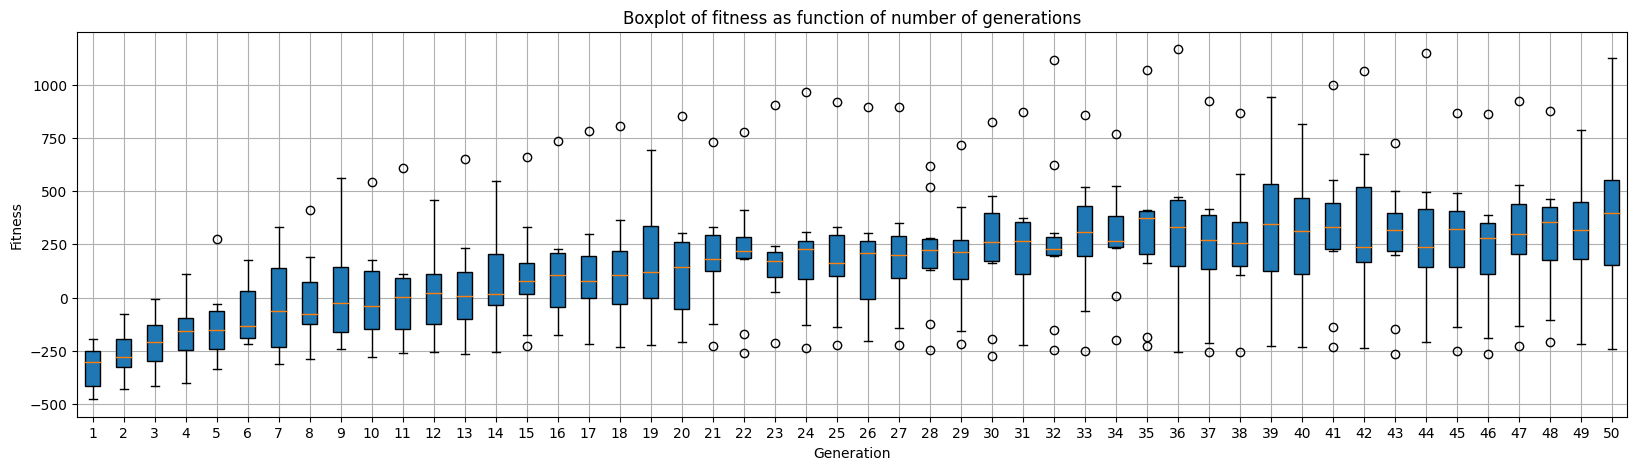

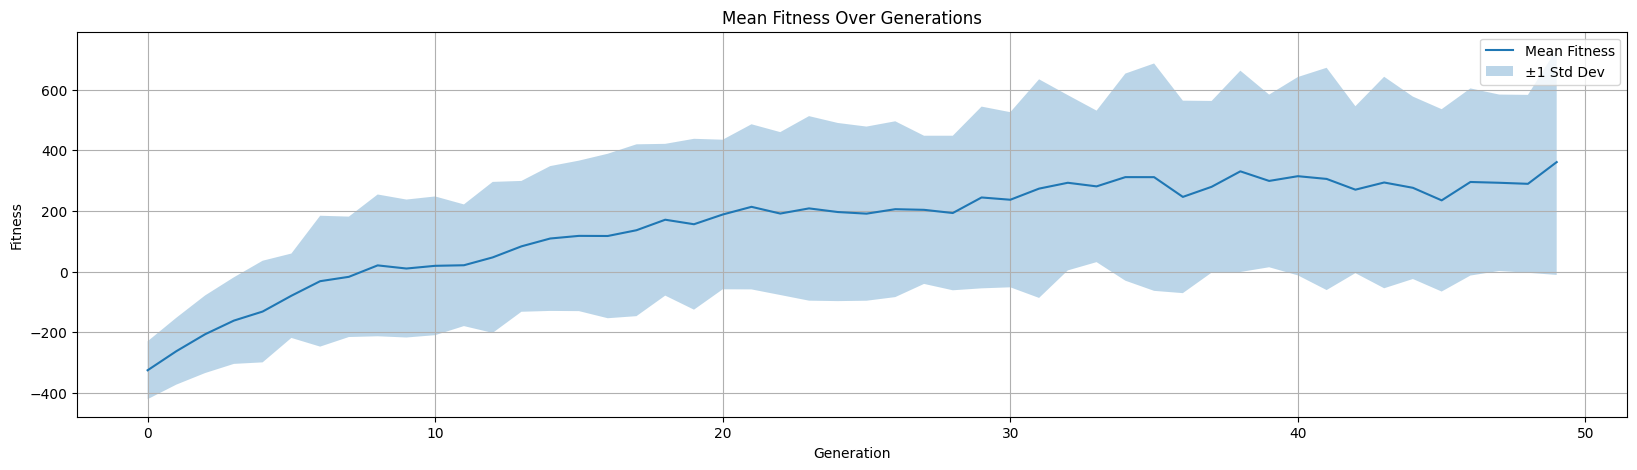

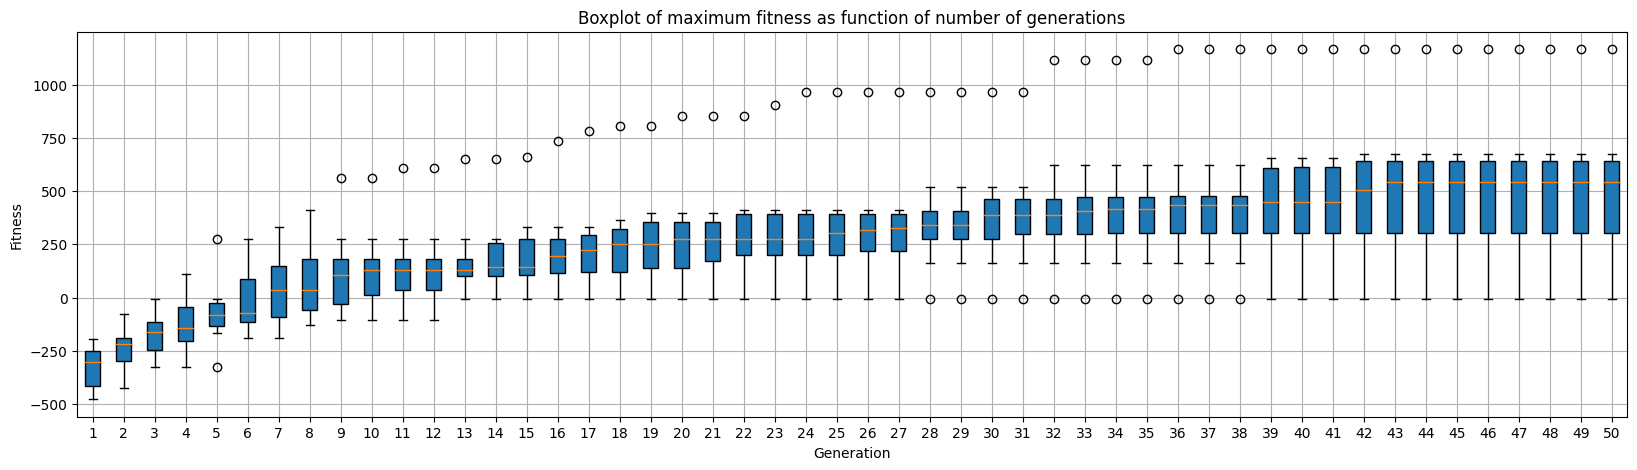

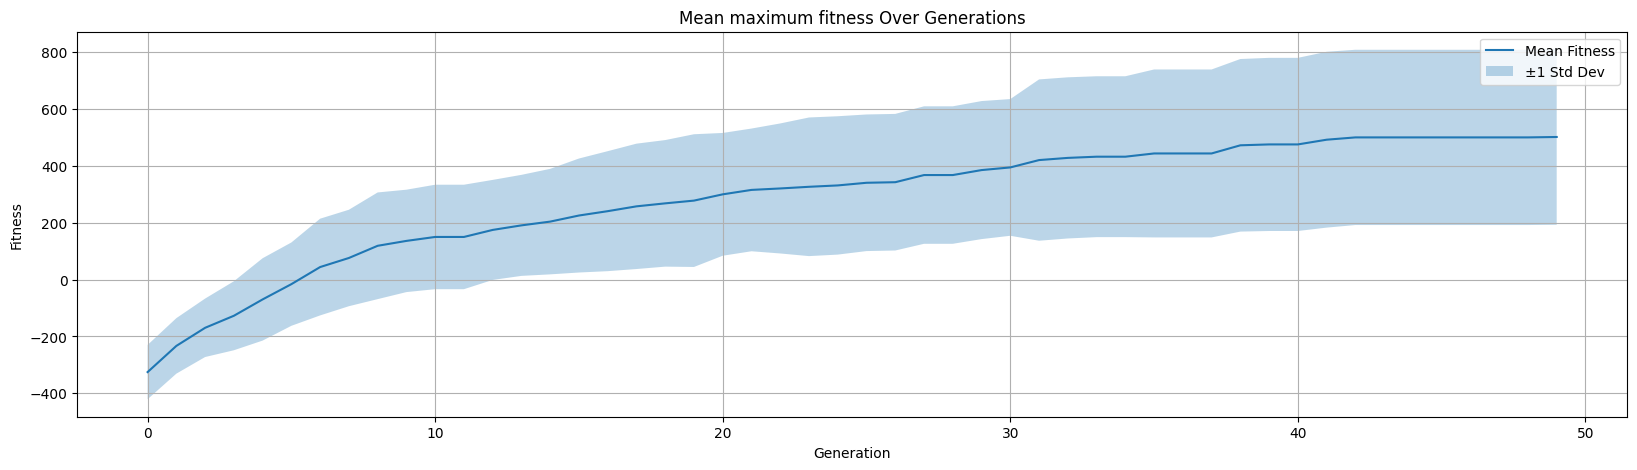

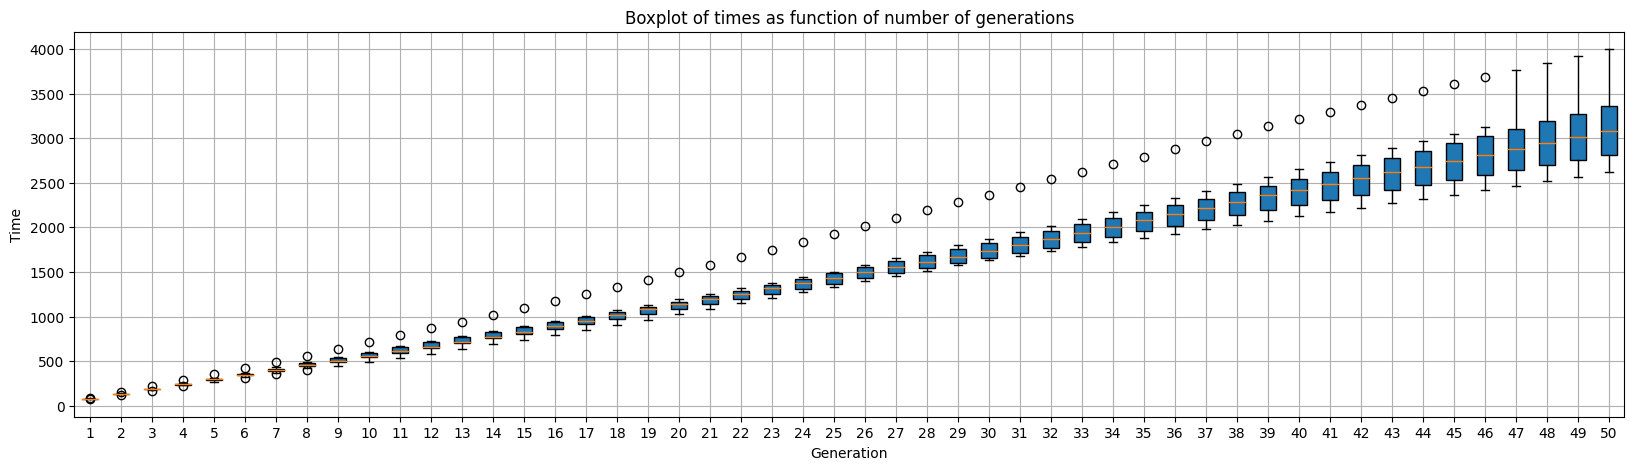

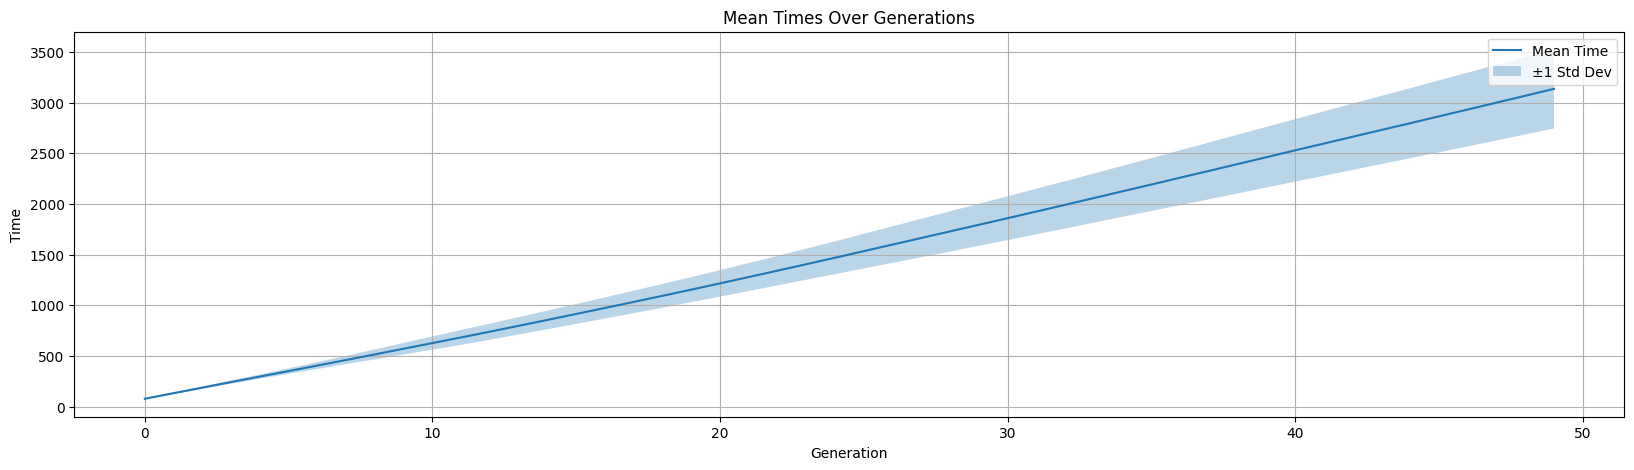

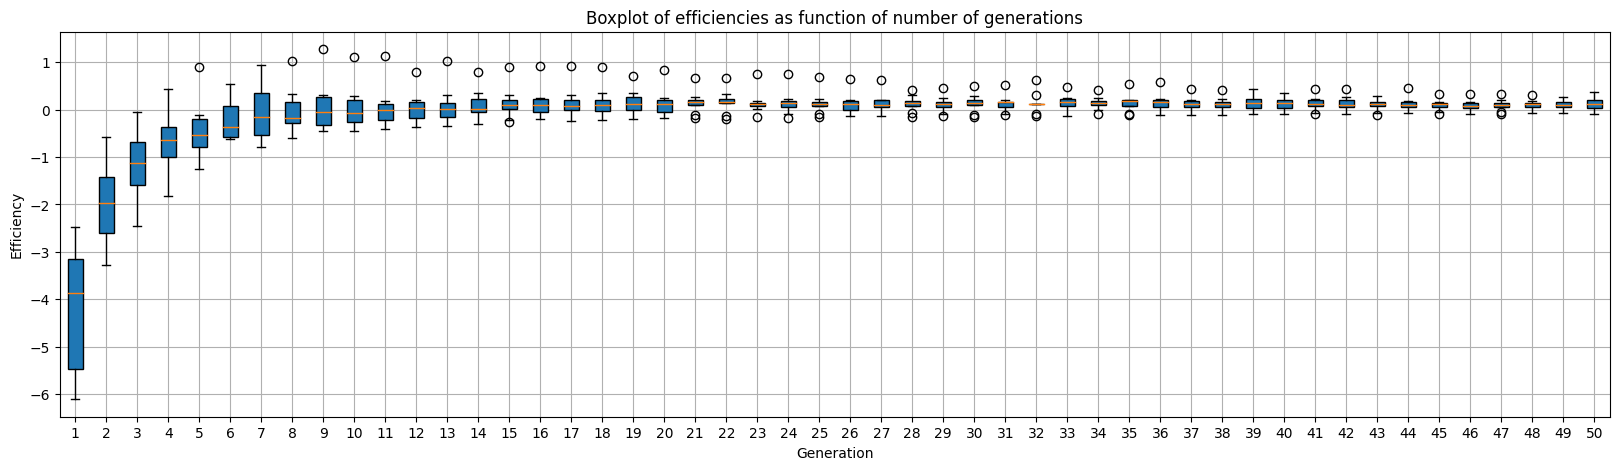

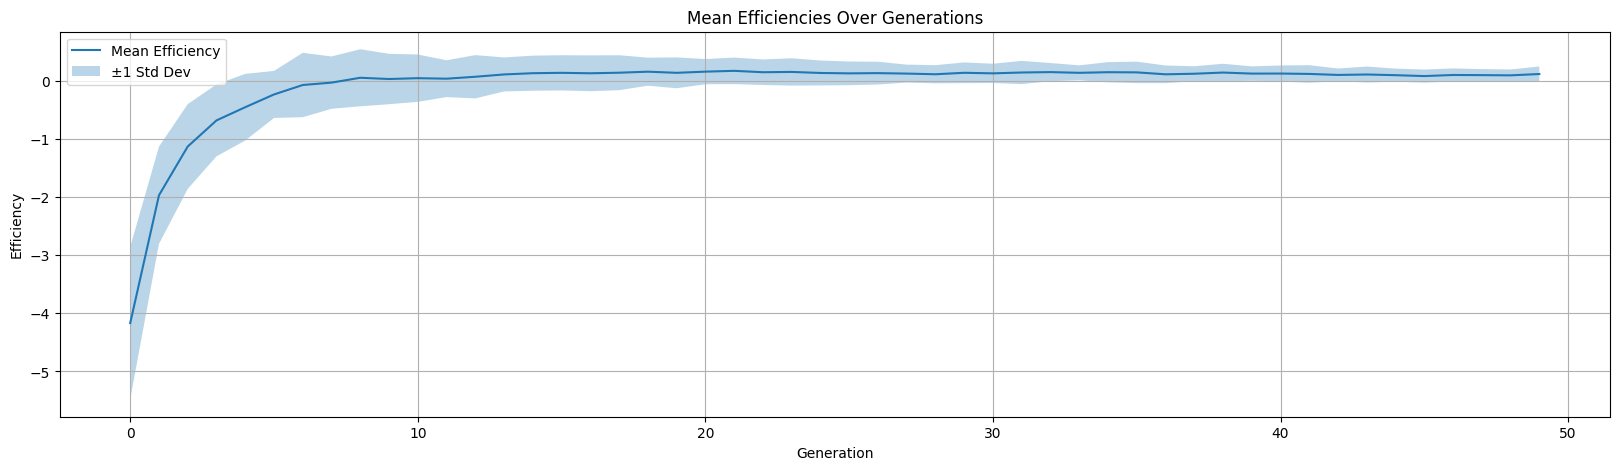

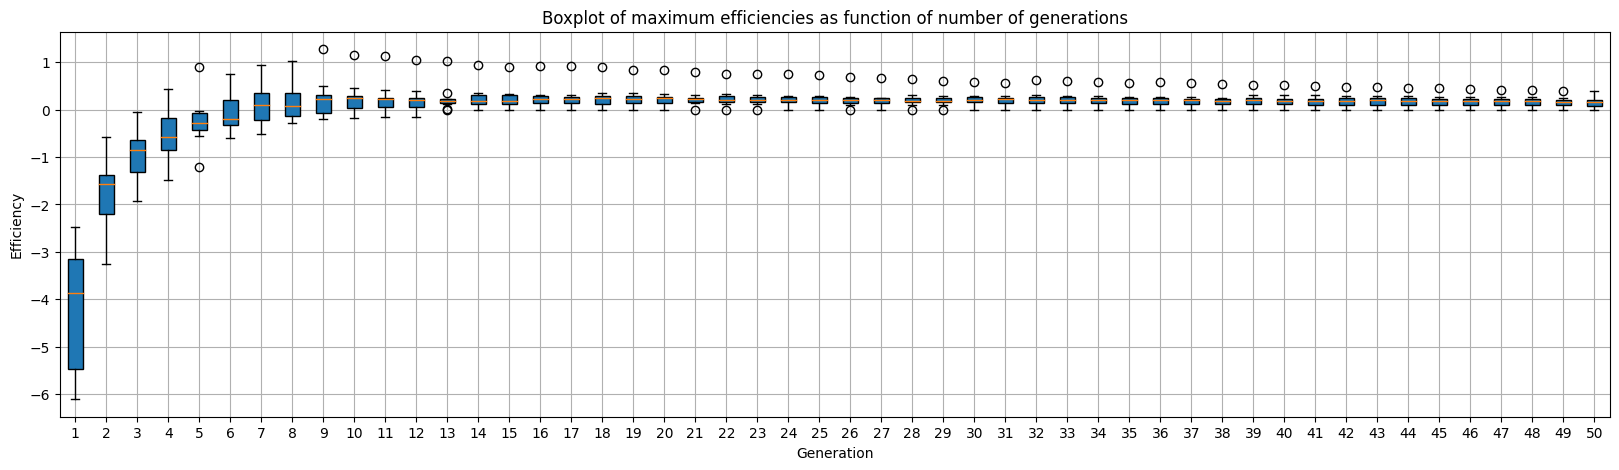

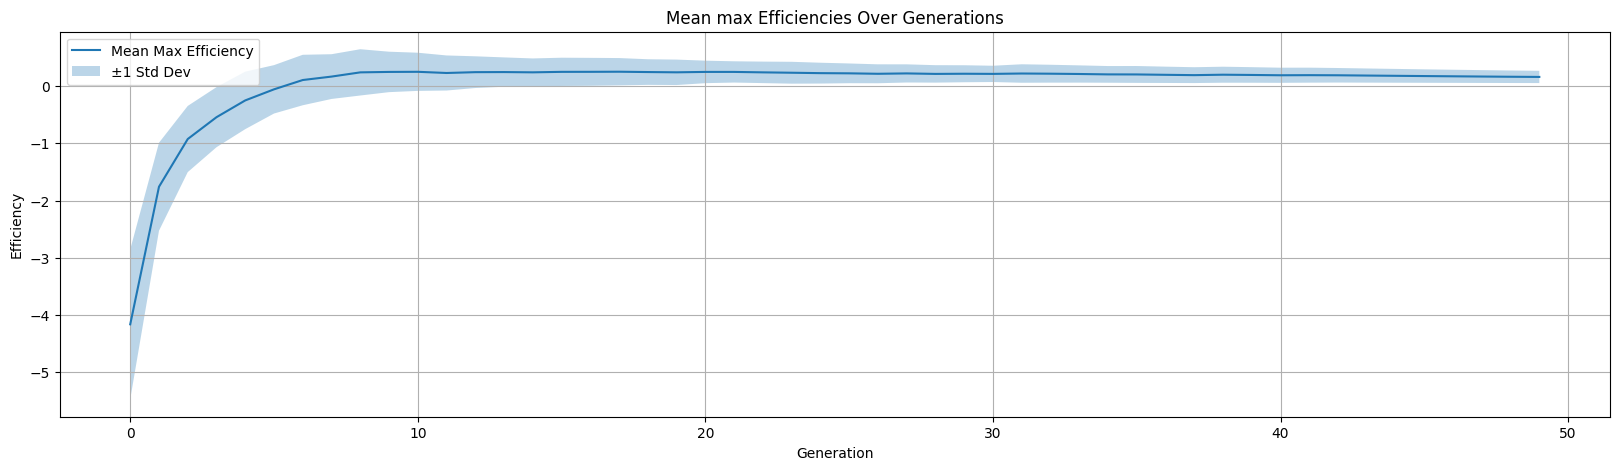

In [ ]:
scores = [[-225.7480328873372, -322.24391713767045, -24.84078375641414, -96.19301332974808, -84.67046746213663, 116.29323373508366, -24.90883348775408, 190.89409795341635, 190.5236520315899, 92.97672046503041, 112.07078725073536, 184.96237777789156, 128.60397524310815, 212.7712799722234, 330.71762429282563, 73.77833840462081, 71.10213132454504, 89.67853691379412, 397.66347647839206, 303.27140249280797, 329.8398535714793, 231.77667557305665, 217.98518907224877, 257.10891966018846, 330.2204453208815, 186.42380012670975, 225.86893906547448, 160.8492736740596, 233.36648316516144, 313.1308194612111, 367.79364208407185, 301.7118270502675, 263.7699695853075, 254.2012827742185, 356.20957330854253, 185.13829531321005, 101.33419424072082, 143.34182464492335, 203.47883858359225, 160.2555731840431, 328.1660626033765, 242.26099571198554, 277.6596736828921, 200.05288750991403, 333.9426372023344, 301.9815415902245, 298.5842199069381, 176.43710840437774, 166.93404735572372, 300.15075005700396], [-250.096005355722, -78.19553801806863, -7.742517032014685, 109.34307252458318, 274.00305241480663, 70.37371317328585, 249.70108900889514, 74.31582278950354, 149.09898679470118, 177.5203426778544, 47.41672668810422, 108.08882770889429, 232.24264630978354, 184.16891856805864, 52.30379472600831, 164.68579973146416, 85.28868046942263, 196.83835151467133, 96.88596023659001, 105.6404528783801, 114.38513155704317, 203.1296575656316, 24.163003197192026, 72.30688462118184, 133.45367228737982, 126.31799252745046, 77.68747968093312, 129.89441798736334, 67.0751422618187, 164.29555324898087, 73.9023564082833, 223.78107866233506, 170.82281678900887, 232.25071320481612, 161.85662237027537, 133.61657327549875, 241.22768401180826, 159.67384201269897, 96.5854588691694, 95.01045024271967, 220.1839255724932, 159.55602582107574, 201.23762967263994, 127.31921899387493, 102.88229739003538, 70.64679230083138, 186.68946165077506, 179.03727743925302, 227.33397386242402, 101.37352391305157], [-261.7058436409696, -215.02839685232482, -127.00376144101782, -8.153894772916914, -231.88826624368764, -187.95345967966102, -220.61454096722645, -243.69933919395206, -226.10389280253273, -208.98426736100058, -258.7101285122918, -257.5670646847171, -262.8329846438602, -254.95925844833815, -227.42393091358437, -177.1581510526644, -218.8251262830484, -231.30851082255788, -222.04349800974023, -210.8324165809812, -229.24046147828278, -260.8717933908937, -212.11620027157517, -237.41107697137178, -224.53578306716298, -204.3428850100136, -224.35482462556388, -248.17706366312945, -219.94246742372965, -273.38271129935583, -222.22887545183886, -246.78651362887604, -248.69056377581774, -197.2143567345442, -227.38912904896694, -256.35768102646784, -255.8080790000602, -253.53884620817684, -228.65148604435765, -232.13901148564594, -232.65338220289698, -238.27951278457942, -264.02872994491645, -207.73085493075257, -251.1588700263523, -264.89586922149164, -227.63588503332537, -206.8025651568264, -218.5120337225966, -243.75609057754997], [-255.34138532520367, -401.313586432272, -355.6034721145418, -335.487646186671, -119.58889027859288, -216.40852229781615, 79.05629052635828, -97.5047456114439, -13.300876524793779, -116.85350815198127, 108.12550485586505, 26.827523324426494, -119.60586777351763, 57.743072829334395, 49.817550461990976, -53.45506781016705, 50.22191714105594, 27.380435508795504, 133.22748702346613, -1.030254813089492, 199.18384977777856, 180.8693459720669, 160.3805107628341, 126.4471963165114, 92.62278910079225, -50.86622019257122, 126.29340555805977, 281.681313588233, 155.8184010857314, 186.3585031722589, 375.1748327119689, 233.26042632916074, 323.2801443979589, 417.33533659566604, 410.39985232834727, 407.7300297367781, 248.79955813073997, 326.7648040272823, 281.09284147953514, 278.3978317747337, 244.23082656330507, 189.2668089499, 498.22668888657404, 260.7487182763991, 365.7986600259862, 259.4305592280805, 298.8279361986438, 375.29821565279894, 305.1041414127415, 369.84553403422694], [-440.6240142050692, -112.98314182553386, -275.5127006577601, -103.14597554266186, -185.7748203287968, -83.50621655125315, 160.1247667787793, 73.20716309830236, -137.32514313601354, -160.411495597343, -172.30174119521428, -200.95155681394493, -230.22495559518984, -30.47332688530517, -174.17410294107543, -152.7433071030436, -215.21029650893166, -189.02459277463169, -49.91075810796582, -72.23525039557273, -122.42265892063237, -172.8009894698271, 97.01752268531388, -130.10835847461084, -138.6284763106944, -102.63092727387244, -141.47711363210936, -124.1390309946975, -158.8221197234633, -192.5716835330609, -154.9147014839648, -152.04017598388756, -61.29010507512027, 6.597182919437188, -184.41801122752247, -163.41603276720062, -213.74687149416116, 104.47718279244776, -70.43913260166656, 38.93226524922849, -140.2416411321151, -155.7342781378839, -147.15088094121188, -58.51880507273321, -136.43328428940097, -192.12109496194375, -134.04953465620497, -107.32083201224754, -145.97730533869998, -129.80908134397947], [-381.5500675412259, -326.83198336983475, -415.57315291958423, -399.9371934474412, -337.5638124894532, -187.66342512242724, -242.90147892698667, -58.458125146075616, 128.3952403456148, -21.123301918262385, -7.505944352106823, 113.08657275199806, -24.09223724077404, -25.292079836119512, 111.82451450785655, 229.41204171242896, 122.98966707994094, 225.8077647110744, 102.5178412938931, 280.0572224609266, 244.04246073691195, 269.4053172133166, 202.30907139581953, 251.58344890604047, 328.2502825068433, 234.79785357066152, 348.2929417351303, 517.2851285176732, 424.68008324504797, 422.3302529689964, 305.9596202813321, 623.509438388949, 517.8835958635937, 525.2287240195114, 391.2353221480091, 465.0503954980899, 289.37782343299784, 579.0093323506123, 462.51498886858104, 420.3522663926949, 377.3730178037489, 676.0299786961855, 278.07680150131057, 497.41361133276916, 490.7300064597306, 360.56137454897436, 472.47809263285177, 428.77935996175984, 608.7289449817171, 421.77065876269705], [-339.59139970767285, -312.253828556955, -304.319915258307, -166.42349520893106, -303.9983071282443, -217.55026885707252, -309.924605171142, -127.7326314793026, -39.49711096757017, 132.44844697778512, -85.5604454225961, 19.00865840831421, 40.00461785911904, 270.6247854264299, 180.5603215696903, 225.4702600781864, 300.0128627289752, 122.56724695960847, 218.363505407411, 200.20785946700838, 146.33507310075683, 410.29238336812364, 241.31417491399054, 269.3727134258256, 196.212882038705, 272.8611150149968, 176.0204423991458, 251.8158239969305, 244.07459002410587, 268.30595091092187, 221.42939633281057, 233.98393248882593, 295.25473942873015, 270.58618871823785, 408.8062232440143, 473.352695311669, 416.87962963508386, 323.5616684837123, 556.7295615595042, 587.8498547869443, 552.5040288005953, 298.09800412251417, 378.323011415683, 306.5530324754477, 419.16689165801745, 238.92643855140747, 347.273988890887, 414.8006286708219, 346.95920614771063, 491.8852542476573], [-477.40506218375333, -185.17659542925833, -202.43391867216923, -145.7210639864411, -28.1096318484377, 174.14717833707186, 332.91684356044294, 409.51153004441085, 562.8886270661068, 544.0445914621127, 606.2790458957006, 458.9080629778968, 648.3705795223846, 549.2983903765928, 660.8730305213171, 735.1194709839667, 781.1859590733511, 807.5962890865299, 693.433012065792, 853.5496207733806, 728.8416326202494, 777.7432905558665, 904.4240114739098, 962.9552421737194, 917.634116689627, 894.3286404825393, 896.7085840266585, 615.9843075208244, 714.9579786511678, 825.6920142939085, 869.2129825284759, 1114.9679803470835, 858.2134932770628, 768.9506476369706, 1068.2984524805665, 1165.8242960539737, 924.388692587233, 866.0605493186209, 943.3074069201114, 814.8470994999111, 996.6212824775822, 1061.7351152391325, 723.2422355121902, 1147.544379989768, 865.315820675374, 861.7616449686032, 922.7475547613554, 875.469775318986, 787.8751727179103, 1124.9849859623803], [-196.30211805413808, -243.48158530754637, -138.90050450778543, -256.1704155684904, -243.33844568031424, -104.35336499907338, -234.57975120041095, -286.67003768708565, -243.06970788830068, -278.1940123689097, -169.15057964050845, -120.12598988110447, 100.84622375127888, -36.77070363001009, 102.8313637073722, 141.62456108737527, 218.95202288851277, 362.16579187560035, 375.3332215645552, 177.99854324144349, 307.1997491703643, 286.1519402437239, 179.32043980094573, 307.65856540186564, 141.21799762980993, 250.69337207418548, 292.1972866341159, 214.51583229258586, 191.00612525398043, 252.09055594042437, 268.06718537225976, 206.22399099031944, 452.2677162123421, 267.4640292973489, 388.686456240026, 256.5744926260405, 291.98266639149466, 184.45647598956344, 655.4315800396562, 480.07370744153, 332.68291260675426, 231.73627758382202, 353.2689761194387, 210.65136830572249, 264.1564601648622, 326.7201275708218, 262.65936405101024, 329.7246313779953, 330.05537766812864, 568.8390839701832], [-426.14780575378086, -427.5367586121454, -214.56616418218132, -214.89750094327133, -57.206860126489644, -160.11752719374513, -105.71765165241035, -106.62994095608596, -167.56232076101134, -60.796043756097276, 9.095027702086412, -123.6571749436348, -45.779185059919605, -95.16006409446342, 2.8975287451420755, -9.543512764836322, -22.538139100950644, -48.5743795768631, -36.00224730558814, -75.78534194200317, 163.6612881685783, 209.23290981649382, 98.20489338228592, 203.3401387548597, 186.86982882588572, 302.27405620735914, 279.64527340171054, 236.2333686859518, 278.84128542983336, 477.10402460709247, 264.152602943181, 196.91646362652958, 356.64631950437604, 264.0094762664704, 340.4986059491307, 445.6701059621232, 417.9043985788128, 361.4627822517473, 405.06776674388607, 345.49791610481856, 466.2479473083506, 590.4584697236293, 401.62698491776683, 453.01568129456376, 307.77251596511525, 385.17200736775004, 526.6811042938264, 462.67686055451486, 484.9115580277909, 604.9208551956972]]
times = [[91.38423299789429, 152.29203343391418, 218.34212160110474, 284.7124991416931, 349.92021107673645, 417.95065665245056, 488.29674887657166, 560.2130918502808, 635.4477558135986, 712.401731967926, 790.5483756065369, 868.5901508331299, 943.5693759918213, 1018.7146897315979, 1097.313212633133, 1174.234071969986, 1253.3851997852325, 1333.5250391960144, 1413.548655986786, 1494.9725563526154, 1577.8857777118683, 1663.5564782619476, 1746.5420186519623, 1833.9350650310516, 1922.3495795726776, 2011.5197677612305, 2102.059766292572, 2192.6073439121246, 2281.631726503372, 2367.062545776367, 2453.2832045555115, 2539.5645570755005, 2623.87992143631, 2708.6137449741364, 2793.79119181633, 2878.056740760803, 2964.036913394928, 3046.075008392334, 3131.493894338608, 3211.3979482650757, 3290.279363155365, 3368.316149711609, 3447.0428960323334, 3527.4822914600372, 3606.3912858963013, 3687.454102039337, 3766.064851284027, 3842.6528379917145, 3920.317453145981, 3998.0431632995605], [79.27942752838135, 134.38902473449707, 189.4001545906067, 245.333731174469, 303.61199164390564, 360.8083264827728, 418.09917545318604, 475.6767168045044, 537.7790911197662, 596.8146159648895, 654.6793177127838, 713.5953936576843, 772.502090215683, 832.9655439853668, 892.6484155654907, 952.6715030670166, 1009.976301908493, 1070.755565404892, 1132.1105408668518, 1192.3663351535797, 1254.0220668315887, 1315.5885660648346, 1376.8583834171295, 1438.0917928218842, 1500.0314455032349, 1564.2988576889038, 1629.655291557312, 1696.0386564731598, 1762.3918941020966, 1832.3964734077454, 1899.649832725525, 1972.1169407367706, 2043.6767172813416, 2116.134331226349, 2188.243881702423, 2259.6974976062775, 2334.068470478058, 2407.3031656742096, 2480.505363225937, 2550.954729318619, 2623.5831921100616, 2694.6080043315887, 2769.617159128189, 2843.544903278351, 2917.1970841884613, 2991.2658739089966, 3064.257563829422, 3137.546834230423, 3210.7161934375763, 3283.226265668869], [75.63329291343689, 130.06498312950134, 186.55108046531677, 241.56194972991943, 297.9076633453369, 356.5109543800354, 412.8454239368439, 472.06296396255493, 530.7991383075714, 589.2831838130951, 646.3648357391357, 705.4213206768036, 762.6032354831696, 821.7657287120819, 880.0358700752258, 938.4809641838074, 996.740532875061, 1055.1925015449524, 1113.7141728401184, 1171.4873638153076, 1231.0633647441864, 1288.9560089111328, 1347.8969683647156, 1406.3672015666962, 1464.024713754654, 1523.5853950977325, 1582.05082321167, 1639.7149085998535, 1699.4125378131866, 1756.894799232483, 1816.3356313705444, 1874.8981504440308, 1933.6229934692383, 1991.3413181304932, 2050.78897857666, 2108.128741502762, 2168.1302428245544, 2225.3953824043274, 2284.1840085983276, 2342.893517971039, 2401.6121180057526, 2460.16349029541, 2519.893861055374, 2578.200761795044, 2636.415867328644, 2695.335476398468, 2754.37561750412, 2813.0504615306854, 2872.684848546982, 2931.7226917743683], [80.47215175628662, 134.19680047035217, 186.4970359802246, 239.67873239517212, 294.27373695373535, 345.98370361328125, 398.1734986305237, 445.57561683654785, 492.4377009868622, 539.2526829242706, 587.6563057899475, 635.5423457622528, 682.7744765281677, 732.8038418292999, 781.0714979171753, 832.3591763973236, 885.0761351585388, 938.156040430069, 993.2290849685669, 1051.3749146461487, 1109.059097290039, 1168.520976305008, 1230.8973853588104, 1295.09517121315, 1361.6085171699524, 1429.8220579624176, 1499.1353197097778, 1567.8716502189636, 1640.4055371284485, 1712.4182541370392, 1787.0414531230927, 1864.1275141239166, 1942.231969833374, 2023.021232366562, 2106.6612944602966, 2186.0097794532776, 2266.2701127529144, 2347.644395828247, 2432.168473958969, 2519.511900663376, 2609.305643796921, 2697.050350666046, 2783.222976922989, 2867.7617189884186, 2948.754936695099, 3034.3111748695374, 3118.5287070274353, 3207.9074709415436, 3293.6945927143097, 3386.1679213047028], [77.8294575214386, 128.80191135406494, 180.62931370735168, 233.7021815776825, 287.9894595146179, 343.1833076477051, 400.0938322544098, 454.875070810318, 507.7009036540985, 561.1938378810883, 612.2290380001068, 662.4179518222809, 715.1289629936218, 769.3788857460022, 825.2276055812836, 880.5186007022858, 936.87033867836, 995.2796902656555, 1054.0702414512634, 1113.030421257019, 1173.7394289970398, 1234.6076669692993, 1294.8888506889343, 1353.080802679062, 1410.8083319664001, 1469.3312208652496, 1527.4628822803497, 1587.4146637916565, 1645.8589043617249, 1704.9856185913086, 1763.0652832984924, 1818.170083284378, 1873.3925831317902, 1926.7733283042908, 1979.8924939632416, 2032.5602400302887, 2086.7805004119873, 2139.528583049774, 2194.7796404361725, 2247.9113569259644, 2303.0870440006256, 2354.8294281959534, 2407.00390958786, 2457.1968586444855, 2510.179148197174, 2563.7707755565643, 2614.798988342285, 2665.963948726654, 2717.174123287201, 2769.787821292877], [72.19246220588684, 121.61871647834778, 169.67386937141418, 220.4664170742035, 269.9503390789032, 318.2871241569519, 368.24831891059875, 422.75092935562134, 478.287410736084, 535.0965378284454, 593.5125451087952, 651.8268694877625, 710.9990971088409, 773.2373201847076, 832.3539996147156, 894.3008167743683, 953.616194486618, 1015.582845211029, 1078.6633100509644, 1142.1301310062408, 1208.7313148975372, 1280.1539206504822, 1354.3130733966827, 1426.7185611724854, 1500.4702723026276, 1575.6170942783356, 1652.3663108348846, 1726.5036778450012, 1799.8595345020294, 1872.9279186725616, 1947.3819406032562, 2020.242154121399, 2096.6230556964874, 2173.67565202713, 2248.8548622131348, 2329.200623512268, 2408.0261075496674, 2489.477826833725, 2568.8924696445465, 2651.082726955414, 2732.875369310379, 2814.4599692821503, 2893.0034816265106, 2970.7695224285126, 3046.6277174949646, 3123.651034593582, 3198.1365303993225, 3275.3695180416107, 3353.275539636612, 3431.137385368347], [79.06800627708435, 135.42796230316162, 189.51135110855103, 245.45253252983093, 296.5413613319397, 347.973819732666, 398.75334310531616, 449.0411388874054, 499.6317870616913, 551.9477052688599, 604.0647292137146, 655.9124104976654, 708.9452805519104, 768.0106363296509, 828.9099082946777, 891.9971780776978, 955.0016086101532, 1018.5004901885986, 1082.0757927894592, 1146.4239201545715, 1209.7893629074097, 1275.1298401355743, 1339.8937182426453, 1405.8093905448914, 1469.9324443340302, 1535.6825704574585, 1599.9416863918304, 1665.8106536865234, 1731.6997594833374, 1799.783394575119, 1866.4784898757935, 1934.1946847438812, 2004.1229705810547, 2073.595554113388, 2145.1454536914825, 2216.342252969742, 2289.002563238144, 2359.873481988907, 2433.3281650543213, 2503.1529924869537, 2575.6387042999268, 2646.0931100845337, 2715.7828707695007, 2784.9165761470795, 2855.4174473285675, 2925.751209497452, 2997.885187149048, 3070.2295129299164, 3141.73002243042, 3211.1802954673767], [78.15777158737183, 136.73725128173828, 188.1839644908905, 234.73679971694946, 275.4959394931793, 315.80931782722473, 357.20975518226624, 399.3269453048706, 441.4513599872589, 486.58279156684875, 532.2359600067139, 579.1987750530243, 632.6249666213989, 687.2772102355957, 739.9451022148132, 796.0418119430542, 852.1864666938782, 907.6964974403381, 966.1816642284393, 1026.7201764583588, 1086.4988350868225, 1148.0217599868774, 1207.7425692081451, 1269.9336459636688, 1330.3971645832062, 1392.7573790550232, 1451.925856590271, 1513.1159925460815, 1575.0797698497772, 1636.469173192978, 1695.7210507392883, 1756.4568464756012, 1818.7886221408844, 1882.5768954753876, 1945.8517122268677, 2010.1350755691528, 2077.9249873161316, 2140.631703853607, 2206.9982056617737, 2273.7098541259766, 2339.9832293987274, 2405.548273563385, 2472.16135764122, 2539.913100004196, 2606.898917913437, 2677.5225903987885, 2746.320793390274, 2815.0562920570374, 2884.165608406067, 2953.070811510086], [77.61456346511841, 132.34274744987488, 191.23042702674866, 251.6364209651947, 309.5289707183838, 368.5685787200928, 429.00322222709656, 487.86190843582153, 546.1051681041718, 605.9838356971741, 663.979790687561, 721.3761677742004, 777.3389265537262, 830.5843985080719, 884.2269153594971, 935.9239354133606, 987.6984875202179, 1036.5071380138397, 1087.0199060440063, 1136.5704839229584, 1186.8572359085083, 1236.680608510971, 1285.5485537052155, 1334.930452823639, 1384.4719879627228, 1434.4210605621338, 1483.7269418239594, 1532.162448167801, 1582.0834991931915, 1631.6799592971802, 1683.1734273433685, 1732.914738893509, 1782.4848041534424, 1831.3296971321106, 1880.9490859508514, 1930.0912725925446, 1978.4029734134674, 2027.002764225006, 2075.1055433750153, 2124.1321012973785, 2173.135940551758, 2220.5714564323425, 2269.4842569828033, 2317.9863476753235, 2366.7482783794403, 2414.8521661758423, 2465.115170240402, 2516.497672557831, 2567.6500537395477, 2620.9379966259003], [77.14395308494568, 130.70361518859863, 184.20698046684265, 238.00378584861755, 292.1143901348114, 342.6755871772766, 393.02054476737976, 444.44869327545166, 493.8082973957062, 545.4595522880554, 596.1575520038605, 646.427741765976, 698.2215840816498, 749.0495607852936, 801.5658795833588, 856.2033679485321, 911.5855894088745, 968.5978813171387, 1021.1210565567017, 1075.8220834732056, 1129.5041818618774, 1182.8484935760498, 1238.0428838729858, 1295.1855618953705, 1352.1928284168243, 1410.751891374588, 1467.8160614967346, 1524.2807059288025, 1577.9361596107483, 1631.9687027931213, 1684.8293907642365, 1741.4408361911774, 1796.8403346538544, 1855.5642185211182, 1911.4469723701477, 1966.1502168178558, 2022.4593274593353, 2076.2645692825317, 2131.3779599666595, 2187.132946252823, 2242.214405298233, 2297.1916608810425, 2353.550502538681, 2413.17107796669, 2470.1766023635864, 2529.8233845233917, 2589.2253153324127, 2650.928023815155, 2710.2559044361115, 2768.0661311149597]]


efficiencies = [[score/time for score,time in zip(score_per_generation,time_per_generation)] for score_per_generation,time_per_generation in zip(scores,times)]


scores = np.array(scores)
times = np.array(times)
efficiencies = np.array(efficiencies)

cumscores = np.maximum.accumulate(scores, axis=1)
cumefficiencies = cumscores/times

# --- scores ---
plt.figure(figsize=(6, 6))
plt.boxplot(scores, patch_artist=True)
plt.title("Boxplot of fitness as function of number of generations")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.grid(True)
plt.show()

mean_scores = np.mean(scores, axis=0)
std_scores = np.std(scores, axis=0)

plt.figure(figsize=(20, 5))
plt.plot(mean_scores, label="Mean Fitness")
plt.fill_between(range(len(mean_scores)), mean_scores - std_scores, mean_scores + std_scores, 
                 alpha=0.3, label="±1 Std Dev")
plt.grid(True)
plt.title("Mean Fitness Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.show()

# --- cumscores ---
plt.figure(figsize=(20, 5))
plt.boxplot(cumscores, patch_artist=True)
plt.title("Boxplot of maximum fitness as function of number of generations")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.grid(True)
plt.show()

mean_scores = np.mean(cumscores, axis=0)
std_scores = np.std(cumscores, axis=0)

plt.figure(figsize=(20, 5))
plt.plot(mean_scores, label="Mean Fitness")
plt.fill_between(range(len(mean_scores)), mean_scores - std_scores, mean_scores + std_scores, 
                 alpha=0.3, label="±1 Std Dev")
plt.grid(True)
plt.title("Mean maximum fitness Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.show()


# --- times ---

plt.figure(figsize=(20, 5))
plt.boxplot(times, patch_artist=True)
plt.title("Boxplot of times as function of number of generations")
plt.xlabel("Generation")
plt.ylabel("Time")
plt.grid(True)
plt.show()

mean_times = np.mean(times, axis=0)
std_times = np.std(times, axis=0)

plt.figure(figsize=(20, 5))
plt.plot(mean_times, label="Mean Time")
plt.fill_between(range(len(mean_times)), mean_times - std_times, mean_times + std_times, 
                 alpha=0.3, label="±1 Std Dev")
plt.grid(True)
plt.title("Mean Times Over Generations")
plt.xlabel("Generation")
plt.ylabel("Time")
plt.legend()
plt.show()

# --- efficiencies ---


plt.figure(figsize=(20, 5))
plt.boxplot(efficiencies, patch_artist=True)
plt.title("Boxplot of efficiencies as function of number of generations")
plt.xlabel("Generation")
plt.ylabel("Efficiency")
plt.grid(True)
plt.show()

mean_eff = np.mean(efficiencies, axis=0)
std_eff = np.std(efficiencies, axis=0)

plt.figure(figsize=(20, 5))
plt.plot(mean_eff, label="Mean Efficiency")
plt.fill_between(range(len(mean_eff)), mean_eff - std_eff, mean_eff + std_eff, 
                 alpha=0.3, label="±1 Std Dev")
plt.grid(True)
plt.title("Mean Efficiencies Over Generations")
plt.xlabel("Generation")
plt.ylabel("Efficiency")
plt.legend()
plt.show()

# --- cum efficiency ---
plt.figure(figsize=(20, 5))
plt.boxplot(cumefficiencies, patch_artist=True)
plt.title("Boxplot of maximum efficiencies as function of number of generations")
plt.xlabel("Generation")
plt.ylabel("Efficiency")
plt.grid(True)
plt.show()

mean_eff = np.mean(cumefficiencies, axis=0)
std_eff = np.std(cumefficiencies, axis=0)

plt.figure(figsize=(20, 5))
plt.plot(mean_eff, label="Mean Max Efficiency")
plt.fill_between(range(len(mean_eff)), mean_eff - std_eff, mean_eff + std_eff, 
                 alpha=0.3, label="±1 Std Dev")
plt.grid(True)
plt.title("Mean max Efficiencies Over Generations")
plt.xlabel("Generation")
plt.ylabel("Efficiency")
plt.legend()
plt.show()


In [46]:
def get_test_score(tree):
    rewards = []

    for i in range(10):
      # get initial state
      observation = env.reset(seed=i)
      observation = observation[0]

      for _ in range(500):    
        # build up the input sample for GP
        input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        # get output (squeezing because it is encapsulated in an array)
        output = tree.get_output_pt(input_sample)
        action = torch.argmax(output)# What goes here?
        observation, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)


        output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        if (terminated or truncated):
            break

    fitness = np.sum(rewards)
    
    return fitness

best = evo.best_of_gens[-1]

print(best.get_readable_repr())
print(get_test_score(best))

['((((x_1+x_4)/(x_5*x_5))*-3.0392754767553303)/((x_4/(x_5+x_4))-(((1.5542978048324585+x_0)-2.9984309673309326)-(3.5659832963908458+x_5))))', '(((x_7/x_0)-((x_6-x_1)-x_3))-(x_5*((x_3/(x_3/(((x_1-x_7)-x_7)*x_3)))+(x_3/x_3))))', '(((x_3-(x_7*x_4))-(x_7/(x_3/x_0)))/((-2.614602511730813+(x_5*x_7))+((x_6/2.0391216693202674)/((x_6/2.0391216693202674)/(x_1-x_4)))))', '(((x_2*(x_4+-2.558073706940395))+x_5)-(((x_0*x_5)-x_4)+(((x_0*x_3)-x_4)+(((x_0*x_3)-x_4)+(x_5*x_3)))))']


C:\Users\Laure\AppData\Roaming\Python\Python310\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


KeyboardInterrupt: 

## Make an animation
Here the best evolved individual is selected and one episode is rendered. Make sure to save your lunar landers over time to track progress and make comparisons.

MovieWriter imagemagick unavailable; using Pillow instead.


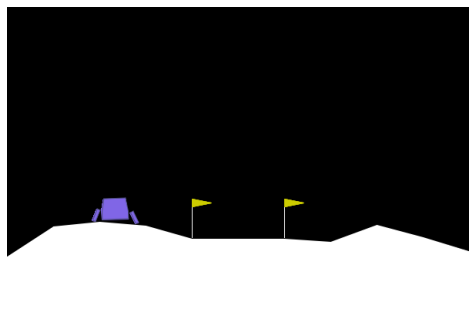

In [21]:
frames = []

# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path='./', filename='evolved_lander.gif'):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
      patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(path + filename, writer='imagemagick', fps=60)

frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames)

## Play animation

<img src="evolved_lander.gif" width="750">

## Optimisation
The coefficients in the multi-tree aren't optimised. Here Q-learning (taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) is used to optimise the weights further. Incorporate coefficient optimisation in training your agent(s). Coefficient Optimisation can be expensive. Think about how often you want to optimise, when, which individuals etc.

LR=0.0001, Run=1/5 → Score=-1615.59
LR=0.0001, Run=2/5 → Score=-1396.11
LR=0.0001, Run=3/5 → Score=-1618.42
LR=0.0001, Run=4/5 → Score=-1609.73
LR=0.0001, Run=5/5 → Score=-1938.00
LR=0.0005, Run=1/5 → Score=-1596.55
LR=0.0005, Run=2/5 → Score=-1405.56
LR=0.0005, Run=3/5 → Score=-1418.77
LR=0.0005, Run=4/5 → Score=-1410.44
LR=0.0005, Run=5/5 → Score=-1470.99
LR=0.0010, Run=1/5 → Score=-1410.15
LR=0.0010, Run=2/5 → Score=-1406.79
LR=0.0010, Run=3/5 → Score=-1450.09
LR=0.0010, Run=4/5 → Score=-2063.44
LR=0.0010, Run=5/5 → Score=-1385.71
LR=0.0050, Run=1/5 → Score=-1489.73
LR=0.0050, Run=2/5 → Score=-1825.30
LR=0.0050, Run=3/5 → Score=-1676.73
LR=0.0050, Run=4/5 → Score=-1406.77
LR=0.0050, Run=5/5 → Score=-1563.16
LR=0.0100, Run=1/5 → Score=-1753.38
LR=0.0100, Run=2/5 → Score=-1784.74
LR=0.0100, Run=3/5 → Score=-1726.85
LR=0.0100, Run=4/5 → Score=-1721.64
LR=0.0100, Run=5/5 → Score=-1658.39
LR=0.0200, Run=1/5 → Score=-1994.74
LR=0.0200, Run=2/5 → Score=-1793.54
LR=0.0200, Run=3/5 → Score=-

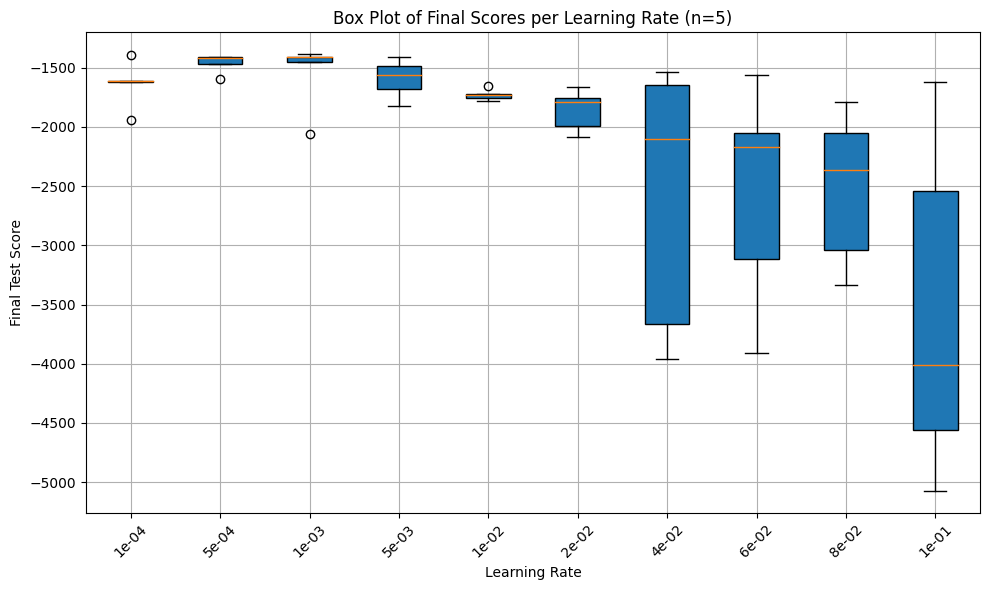

In [34]:
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import numpy as np

learning_rates = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 2e-2, 4e-2, 6e-2, 8e-2, 1e-1]
num_runs_per_lr = 5
batch_size = 128
GAMMA = 0.99

all_scores = []  # List of lists: each sublist = scores for one LR

for lr in learning_rates:
    lr_scores = []

    for run in range(num_runs_per_lr):
        model = copy.deepcopy(best)
        constants = model.get_subtrees_consts()

        if len(constants) > 0:
            optimizer = optim.AdamW(constants, lr=lr, amsgrad=True)

        # Training loop
        for _ in range(500):
            if len(constants) > 0 and len(evo.memory) > batch_size:
                target_tree = copy.deepcopy(model)

                transitions = evo.memory.sample(batch_size)
                batch = Transition(*zip(*transitions))

                non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
                non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
                state_batch = torch.cat(batch.state)
                action_batch = torch.cat(batch.action)
                reward_batch = torch.cat(batch.reward)

                state_action_values = model.get_output_pt(state_batch).gather(1, action_batch)
                next_state_values = torch.zeros(batch_size, dtype=torch.float)

                with torch.no_grad():
                    next_state_values[non_final_mask] = target_tree.get_output_pt(non_final_next_states).max(1)[0].float()

                expected_state_action_values = (next_state_values * GAMMA) + reward_batch

                loss = nn.SmoothL1Loss()(state_action_values, expected_state_action_values.unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_value_(constants, 100)
                optimizer.step()

        score = get_test_score(model)
        print(f"LR={lr:.4f}, Run={run+1}/{num_runs_per_lr} → Score={score:.2f}")
        lr_scores.append(score)

    all_scores.append(lr_scores)

# 📊 Box plot
plt.figure(figsize=(10, 6))
plt.boxplot(all_scores, positions=range(len(learning_rates)), patch_artist=True)
plt.xticks(range(len(learning_rates)), [f"{lr:.0e}" for lr in learning_rates], rotation=45)
plt.xlabel("Learning Rate")
plt.ylabel("Final Test Score")
plt.title(f"Box Plot of Final Scores per Learning Rate (n={num_runs_per_lr})")
plt.grid(True)
plt.tight_layout()
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


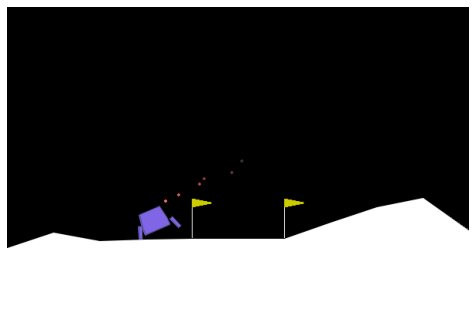

In [32]:
frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames, filename='evolved_lander_RL.gif')

<img src="evolved_lander_RL.gif" width="750">